## Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels
!pip install tqdm
!pip install colorama
!pip install pyliftover

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
import math
import glob
from pyliftover import LiftOver
import requests
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
gene_annotation_file_path = data_path + 'gencode.v44.basic.annotation.gtf.gz'
epi25_variants_file_path = data_path + 'epi25_variant_results.tsv.gz'
constraint_predictions_file_path = results_path + f'HMM_rgc_0.9_over20_chr2_predictions_rgc_wes.tsv.gz'
alpha_missense_file_path = data_path + 'AlphaMissense_hg38.tsv.gz'

## Define helper methods

In [3]:
def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = stats.fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):    
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])

    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

def calculate_effect_size_and_variance(cases_df):
    ALT_AJ = cases_df['ac_case']
    ALT_ExAC = cases_df['ac_ctrl']
    REF_AJ = cases_df['an_case'] - cases_df['ac_case']
    REF_ExAC = cases_df['an_ctrl'] - cases_df['ac_ctrl']

    cases_df['effect_size'] = np.log(((0.5 + ALT_AJ) * (0.5 + REF_ExAC)) / ((0.5 + REF_AJ) * (0.5 + ALT_ExAC)))
    cases_df['var_effect_size'] = (1 / (0.5 + REF_AJ) + 1 / (0.5 + REF_ExAC) + 1 / (0.5 + ALT_AJ) + 1 / (0.5 + ALT_ExAC))
    
    return cases_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
def fisher_method(p1, p2):
    p_values = np.array([p1, p2])
    
    if np.isnan(p1) and np.isnan(p2):
        return None
    if np.isnan(p1):
        return p2
    if np.isnan(p2):
        return p1

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    p_comb = 1 - stats.chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return p_comb
    
def plot_group_QQ(significance_df):
    # Get unique groups
    unique_groups = significance_df['group'].unique()

    # Number of unique groups
    num_groups = len(unique_groups)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_groups, 1, figsize=(8, 4 * num_groups))

    # Loop over each group and create a Q-Q plot
    for i, group in enumerate(unique_groups):
        # Filter the DataFrame for the current group
        group_df = significance_df[significance_df['group'] == group]

        # Calculate -log10(p-values)
        group_df['minus_log_pvalue'] = -np.log10(group_df['p_value'])

        # Sort by p-value in ascending order
        group_df = group_df.sort_values('p_value', ascending=True)

        # Calculate theoretical quantiles
        theoretical_quantiles = stats.norm.ppf((np.arange(1, len(group_df) + 1) / (len(group_df) + 1)))

        # Transform theoretical quantiles into -log10(p-values)
        group_df['theoretical_quantiles'] = -np.log10(stats.norm.cdf(theoretical_quantiles))

        # Plotting the Q-Q plot for the group
        ax = axs[i] if num_groups > 1 else axs
        ax.scatter(group_df['theoretical_quantiles'], group_df['minus_log_pvalue'], label=f'Observed -log10(p-value) for group {group}')

        # Define x for the expected line and confidence intervals
        x = np.linspace(min(group_df['theoretical_quantiles']), max(group_df['theoretical_quantiles']), 100)
        y = x
        ax.plot(x, y, color='r', ls='--', label='Expected -log10(p-value)')
        ax.fill_between(x, y - 1.96*np.sqrt((1-x)*x/len(group_df)), y + 1.96*np.sqrt((1-x)*x/len(group_df)), color='r', alpha=0.2)

        # Labeling significant genes
        significant_genes = group_df[group_df['p_value'] < .0001]
        for idx, row in significant_genes.iterrows():
            ax.text(row['theoretical_quantiles'], row['minus_log_pvalue'], row['gene_name'], fontsize=6)

        # Labeling the plot
        ax.set_xlabel('Expected -log10(p-value)')
        ax.set_ylabel('Observed -log10(p-value)')
        ax.set_title(f'Q-Q Plot of Gene P-Values for Group {group}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# def plot_epilepsy_results_grid(x_pvalue_df, y_pvalue_df, xtitle='Damaging Missense', ytitle='Unified Model')
    
#     for group in unified_model_df['group'].unique():
#         file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
#         files = glob.glob(file_pattern)

#         if files:
#             results_pub_df = pd.read_csv(files[0], sep=",")
#             merged_pub_df = pd.merge(unified_model_df[unified_model_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

#             merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_unified'])
#             merged_pub_df['minus_log_missense_pval'] = -np.log10(np.minimum(merged_pub_df['Damaging Missense p‑val'], merged_pub_df['PTV p‑val']))

#             # Set up the plot
#             plt.figure(figsize=(8, 6))

#             # Replace Inf values with NaN
#             merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#             # Calculate the minimum p-value, ignoring NaN values
#             min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

#             # Calculate the maximum p-value, ignoring NaN values
#             max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

#             # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
#             if np.isnan(min_pval):
#                 min_pval = 0  # or some other default value
#             if np.isnan(max_pval):
#                 max_pval = 1  # or some other default value

#             # Create a hexbin (smoothscatter) plot with log scale
#             plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues', norm=LogNorm())

#             # Add a diagonal line
#             plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

#             # Annotate points with larger fontsize
#             for _, row in merged_pub_df.iterrows():
#                 if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
#                     plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=10)

#             # Set axis limits
#             plt.xlim(min_pval, max_pval)
#             plt.ylim(min_pval, max_pval)

#             # Axis labels and title (bolded)
#             plt.xlabel(xtitle + r' $-log_{10}(p)$', fontsize=12)
#             plt.ylabel(ytitle + r' $-log_{10}(p)$', fontsize=12)
#             plt.title(f'{ytitle} vs {xtitle} p-values for epilepsy group: {group}', fontsize=14, fontweight="bold")

#             # Show color bar
#             plt.colorbar(label='Log-Scaled Count')

#             plt.show()

#         else:
#             print(f"No files found for group {group}")

## Load data

In [4]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(gene_annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df['std_gene_id'] = gene_df['gene_id'].str.split('.').str[0]

gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name,std_gene_id
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201,ENSG00000284733
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201,ENSG00000284662
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209,ENSG00000187634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201,ENSG00000212907
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201,ENSG00000198886
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201,ENSG00000198786
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201,ENSG00000198695


In [6]:
# Read the data into a DataFrame
epi25_variant_results_df = pd.read_csv(epi25_variants_file_path, sep='\t')

# Split locus into chr and pos and convert to integers
epi25_variant_results_df[['chr', 'pos']] = epi25_variant_results_df['locus'].str.split(':', expand=True)
epi25_variant_results_df['pos'] = epi25_variant_results_df['pos'].astype(int)

# Filter out rows
epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['chr'] != "chrX") & (epi25_variant_results_df['chr'] != "chrY") & (epi25_variant_results_df['chr'] != "chrMT")]
epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['consequence'] != "synonymous") & 
                                                    (epi25_variant_results_df['consequence'] != "non_coding") & 
                                                    (epi25_variant_results_df['consequence'] != "NA")]

# Add gene names
epi25_variant_results_df = pd.merge(epi25_variant_results_df, gene_df[['std_gene_id', 'gene_name']].drop_duplicates(), left_on='gene_id', right_on='std_gene_id', how='left').drop('std_gene_id', axis=1)

epi25_variant_results_df

,locus,alleles,gene_id,consequence,hgvsc,hgvsp,mpc,polyphen,group,variant_id,...,an_case,ac_ctrl,an_ctrl,estimate,chi_sq_stat,p_value,in_analysis,chr,pos,gene_name
0,chr1:69731,"[""T"",""C""]",ENSG00000186092,damaging_missense,c.641T>C,p.Ile214Thr,3.3624,probably_damaging,EPI,chr1:69731:T:C,...,37174,0,55408,NaN,NaN,NaN,True,chr1,69731,OR4F5
1,chr1:69731,"[""T"",""C""]",ENSG00000186092,damaging_missense,c.641T>C,p.Ile214Thr,3.3624,probably_damaging,NAFE,chr1:69731:T:C,...,16300,0,55408,NaN,NaN,NaN,True,chr1,69731,OR4F5
2,chr1:69923,"[""T"",""G""]",ENSG00000186092,other_missense,c.833T>G,p.Ile278Ser,2.3070,benign,EPI,chr1:69923:T:G,...,30002,0,43218,NaN,NaN,NaN,True,chr1,69923,OR4F5
3,chr1:69928,"[""T"",""A""]",ENSG00000186092,damaging_missense,c.838T>A,p.Tyr280Asn,4.3167,probably_damaging,EPI,chr1:69928:T:A,...,30156,0,43308,NaN,NaN,NaN,True,chr1,69928,OR4F5
4,chr1:69928,"[""T"",""A""]",ENSG00000186092,damaging_missense,c.838T>A,p.Tyr280Asn,4.3167,probably_damaging,NAFE,chr1:69928:T:A,...,13296,0,43308,NaN,NaN,NaN,True,chr1,69928,OR4F5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11716909,chr22:50782272,"[""G"",""A""]",ENSG00000079974,other_missense,c.23C>T,p.Pro8Leu,NaN,benign,NAFE,chr22:50782272:G:A,...,18438,1,64916,NaN,NaN,NaN,NaN,chr22,50782272,RABL2B
11716910,chr22:50782272,"[""G"",""T""]",ENSG00000079974,other_missense,c.23C>A,p.Pro8Gln,NaN,benign,EPI,chr22:50782272:G:T,...,41956,0,64916,NaN,NaN,NaN,NaN,chr22,50782272,RABL2B
11716911,chr22:50782285,"[""C"",""T""]",ENSG00000079974,other_missense,c.10G>A,p.Asp4Asn,NaN,benign,EPI,chr22:50782285:C:T,...,41954,0,64092,NaN,NaN,NaN,NaN,chr22,50782285,RABL2B
11716912,chr22:50782286,"[""T"",""G""]",ENSG00000079974,other_missense,c.9A>C,p.Glu3Asp,NaN,benign,EPI,chr22:50782286:T:G,...,41954,0,64054,NaN,NaN,NaN,NaN,chr22,50782286,RABL2B


In [7]:
# Filter variants dataframe for analysis
variants_df = epi25_variant_results_df

variants_df = variants_df[(variants_df['ac_ctrl'] + variants_df['ac_case'] <= 5) &
                          (variants_df['an_case'] > 0) &
                          (variants_df['an_ctrl'] > 0)]

In [4]:
# Load in saved predictions for rgc dataset
constraint_predictions_df = pd.read_csv(constraint_predictions_file_path, sep='\t')

constraint_predictions_df

,chr,pos,prob_0,prob_1,observation
0,chr1,925922,9.218631e-34,1.000000,0.0
1,chr1,925923,2.515628e-03,0.997484,1.0
2,chr1,925924,2.518103e-03,0.997482,0.0
3,chr1,925925,4.543584e-05,0.999955,1.0
4,chr1,925926,2.596411e-03,0.997404,1.0
...,...,...,...,...,...
28933587,chr22,50777975,5.029692e-05,0.999950,1.0
28933588,chr22,50777976,7.197833e-05,0.999928,1.0
28933589,chr22,50777977,3.225875e-02,0.967741,1.0
28933590,chr22,50777978,5.462209e-01,0.453779,0.0


In [6]:
constraint_predictions_df['prob_0'].unique().size

5968741

In [9]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)

alpha_missense_df

,chr,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,transcript,transcript_num
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign,ENST00000335137,4
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign,ENST00000335137,4
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign,ENST00000335137,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71697551,chrY,57196925,T,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521C,0.1903,likely_benign,ENST00000244174,10_PAR_Y
71697552,chrY,57196925,T,C,hg38,Q01113,ENST00000244174.10_PAR_Y,F521S,0.2045,likely_benign,ENST00000244174,10_PAR_Y
71697553,chrY,57196925,T,A,hg38,Q01113,ENST00000244174.10_PAR_Y,F521Y,0.1440,likely_benign,ENST00000244174,10_PAR_Y
71697554,chrY,57196926,C,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521L,0.5879,likely_pathogenic,ENST00000244174,10_PAR_Y


## Build Unified constraint, pathogenicity, and pLoF model

In [7]:
# Subset to useful columns
constraint_predictions_df = constraint_predictions_df[['chr', 'pos', 'prob_0']]

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
max_am_pathogenicity_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# copy variants df
pLoF_ind_variants_df = variants_df

# Create indicator column for pLoF variants
pLoF_ind_variants_df['pLoF_ind'] = (variants_df['consequence'] == "pLoF").astype('int32')

# Subset to useful columns
pLoF_ind_variants_df = pLoF_ind_variants_df[['chr', 'pos', 'gene_id', 'gene_name', 'group', 'ac_case', 'an_case', 'ac_ctrl', 'an_ctrl', 'pLoF_ind']]

# Calculate effect size and variance
pLoF_ind_variants_df = calculate_effect_size_and_variance(pLoF_ind_variants_df)

# Merge constraint predictions, am_pathogenicity predictions, and non_pLoF variants based on chromosome and position
constraint_pathogenicity_pLoF_df = pd.merge(pLoF_ind_variants_df, pd.merge(constraint_predictions_df, max_am_pathogenicity_df, on=['chr', 'pos'], how='inner'), on=['chr', 'pos'], how='inner')

# Write merged_df to a csv to repeat analysis in R
constraint_pathogenicity_pLoF_df.to_csv(results_path + f"constraint_am_epi25_pLoF.tsv.gz", index=False, compression='gzip', sep='\t')

constraint_pathogenicity_pLoF_df

,chr,pos,gene_id,gene_name,group,ac_case,an_case,ac_ctrl,an_ctrl,pLoF_ind,effect_size,var_effect_size,prob_0,am_pathogenicity
0,chr1,925946,ENSG00000187634,SAMD11,DEE,0,3876,1,66886,0,1.749437,2.666940,0.000050,0.9876
1,chr1,925946,ENSG00000187634,SAMD11,EPI,0,41956,1,66886,0,-0.632263,2.666705,0.000050,0.9876
2,chr1,925946,ENSG00000187634,SAMD11,GGE,0,10996,1,66886,0,0.706793,2.666773,0.000050,0.9876
3,chr1,925946,ENSG00000187634,SAMD11,NAFE,0,18438,1,66886,0,0.189929,2.666736,0.000050,0.9876
4,chr1,925948,ENSG00000187634,SAMD11,EPI,2,41958,0,66886,0,2.075802,2.400039,0.000040,0.9460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9142394,chr22,50777959,ENSG00000079974,RABL2B,NAFE,0,18438,1,66888,0,0.189959,2.666736,0.391475,0.4255
9142395,chr22,50777974,ENSG00000079974,RABL2B,DEE,0,3876,1,66888,0,1.749467,2.666940,0.010142,0.9569
9142396,chr22,50777974,ENSG00000079974,RABL2B,EPI,0,41958,1,66888,0,-0.632281,2.666705,0.010142,0.9569
9142397,chr22,50777974,ENSG00000079974,RABL2B,GGE,0,10998,1,66888,0,0.706641,2.666773,0.010142,0.9569


In [4]:
# Read the data from the file
constraint_pathogenicity_pLoF_df = pd.read_csv(results_path + f'constraint_am_epi25_pLoF.tsv.gz', sep='\t')

# Initialize lists to store results
meta_model_results = []

input_df = constraint_pathogenicity_pLoF_df
input_df[['log_constraint', 'log_pathogenicity']] = -np.log(1-input_df[['prob_0', 'am_pathogenicity']])

# Group data by gene_id, gene_name, and group
grouped_gene_data = input_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for gene_key, gene_data in tqdm(grouped_gene_data, desc="Processing genes", unit="gene"):
    gene_id, gene_name, group = gene_key
    
    # Meta-regression model for the gene
    X = sm.add_constant(gene_data[['log_constraint', 'log_pathogenicity', 'pLoF_ind']])
    y = gene_data['effect_size']
    weights = 1 / gene_data['var_effect_size']

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()
        
        # Append results to the list
        meta_model_results.append({
            'gene_id': gene_id,
            'gene_name': gene_name,
            'group': group,
            'p_constraint': model.pvalues['log_constraint'],
            'p_pathogenicity': model.pvalues['log_pathogenicity'],
            'p_pLoF': model.pvalues['pLoF_ind'],
            'p_const': model.pvalues['const'],
            'p_unified': model.f_pvalue
        })

    except:
        pass

# Create a DataFrame from the results
unified_model_df = pd.DataFrame(meta_model_results)

# Save the DataFrame to a compressed CSV file
unified_model_df.to_csv(results_path + "epilepsy_unified_model_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
unified_model_df

Processing genes:  98%|███████████████████████████████████████████████████████ | 70971/72250 [05:30<00:05, 214.56gene/s]


,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_pLoF,p_const,p_unified
0,ENSG00000000419,DPM1,DEE,0.921666,0.427682,0.032662,2.749732e-16,0.145844
1,ENSG00000000419,DPM1,EPI,0.452711,0.928062,0.001000,3.518679e-01,0.006660
2,ENSG00000000419,DPM1,GGE,0.969067,0.420388,0.003825,1.149988e-06,0.020369
3,ENSG00000000419,DPM1,NAFE,0.605102,0.722610,0.007375,7.121449e-03,0.042602
4,ENSG00000000457,SCYL3,DEE,0.566119,0.777875,0.028370,2.860911e-52,0.153311
...,...,...,...,...,...,...,...,...
69381,ENSG00000285982,ENSG00000285982,NAFE,0.377649,0.525788,0.840229,1.367607e-06,0.643573
69382,ENSG00000285991,ENSG00000285991,DEE,0.009737,0.014752,NaN,2.634610e-12,0.002721
69383,ENSG00000285991,ENSG00000285991,EPI,0.557667,0.961258,NaN,1.695844e-01,0.839989
69384,ENSG00000285991,ENSG00000285991,GGE,0.694397,0.562096,NaN,3.861340e-07,0.751356


In [4]:
unified_model_df = pd.read_csv(results_path + "epilepsy_unified_model_pvalues.tsv.gz", sep='\t')

filter_mask = (unified_model_df['p_unified'] < 1e-4) | (unified_model_df['p_constraint'] < 1e-4)
gene_name_mask = (unified_model_df['gene_name'] == 'CACNA1A')

pd.set_option('display.max_rows', 250)
unified_model_df[filter_mask].sort_values('p_unified')

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_pLoF,p_const,p_unified
17985,ENSG00000119801,YPEL5,GGE,2.591759e-01,7.044182e-01,3.166830e-29,2.995607e-28,2.190708e-28
203,ENSG00000004776,HSPB6,NAFE,1.767758e-01,5.739612e-01,1.719340e-18,4.918547e-18,1.267898e-17
45911,ENSG00000170180,GYPA,NAFE,3.601940e-15,5.025501e-01,NaN,1.039304e-10,2.382655e-16
30903,ENSG00000144285,SCN1A,DEE,1.309087e-04,1.181671e-05,1.436895e-06,1.042206e-70,6.920892e-16
48910,ENSG00000174021,GNG5,EPI,1.661492e-14,3.558674e-15,NaN,1.085804e-14,4.631283e-15
...,...,...,...,...,...,...,...,...
1474,ENSG00000023191,RNH1,DEE,6.636507e-05,7.756310e-01,6.188717e-01,7.473831e-55,1.045481e-03
61688,ENSG00000204160,ZDHHC18,DEE,8.455998e-05,3.139933e-01,8.531196e-01,6.064061e-25,1.082809e-03
69173,ENSG00000285188,ENSG00000285188,DEE,8.568535e-05,4.843111e-01,5.081147e-01,4.891908e-55,1.096620e-03
26121,ENSG00000136450,SRSF1,DEE,2.963618e-16,8.427338e-12,NaN,2.809108e-16,1.000000e+00


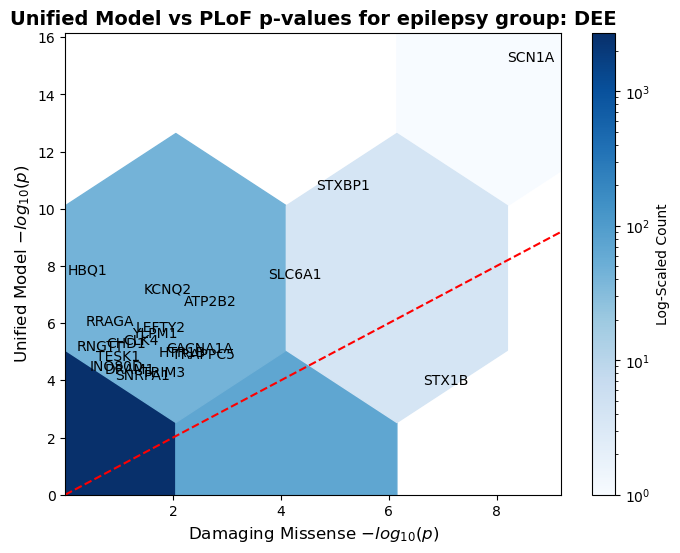

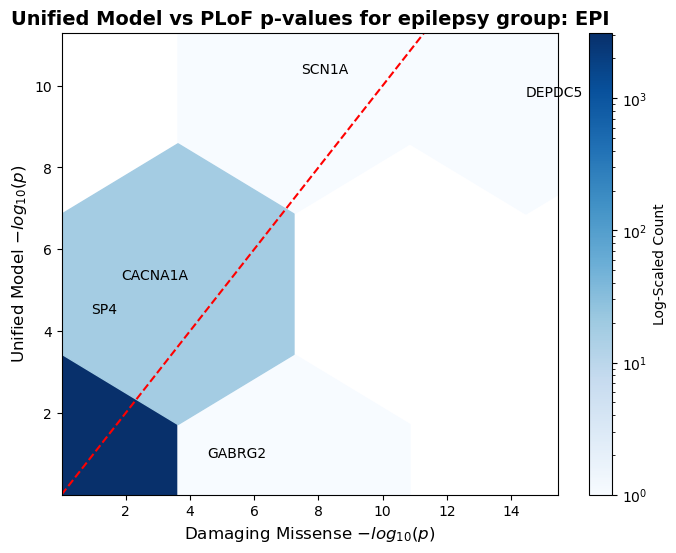

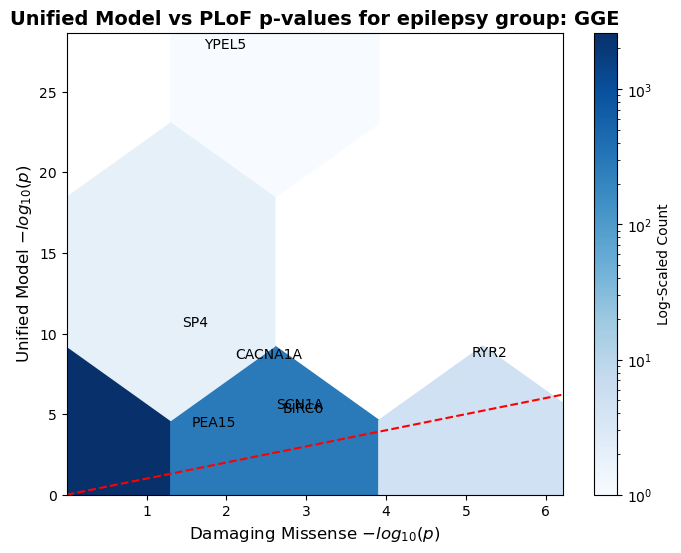

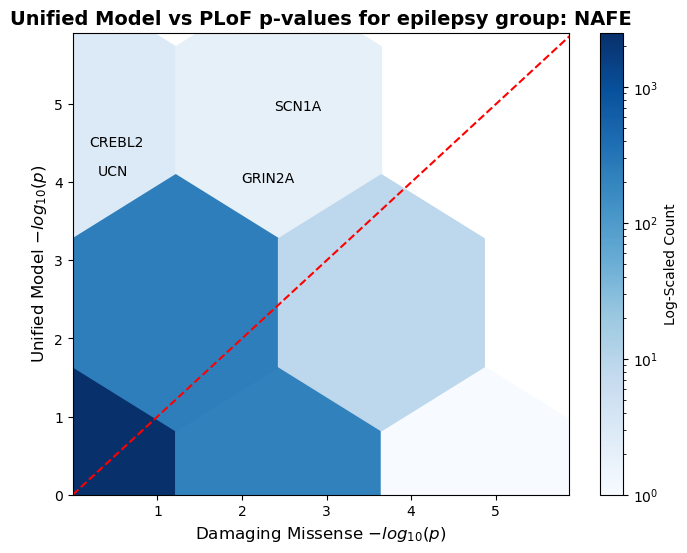

In [32]:
for group in unified_model_df['group'].unique():
    file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(unified_model_df[unified_model_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_unified'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(np.minimum(merged_pub_df['Damaging Missense p‑val'], merged_pub_df['PTV p‑val']))

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval_x = merged_pub_df['minus_log_missense_pval'].min()
        min_pval_y = merged_pub_df['minus_log_pval'].min()
        min_pval = np.nanmin([min_pval_x, min_pval_y])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval_x = merged_pub_df[~merged_pub_df['minus_log_pval'].isna()]['minus_log_missense_pval'].max()
        max_pval_y = merged_pub_df[~merged_pub_df['minus_log_missense_pval'].isna()]['minus_log_pval'].max()
        max_pval = np.nanmax([max_pval_x, max_pval_y])
        
#         print(merged_pub_df[merged_pub_df['minus_log_pval'] == max_pval_y])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value

        # Create a hexbin (smoothscatter) plot with log scale
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line
        plt.plot([0, max_pval+1], [0, max_pval+1], color='red', linestyle='--')
        
        # Annotate points with larger fontsize
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=10)

        # Set axis limits
        plt.xlim(min_pval_x, max_pval_x+1)
        plt.ylim(min_pval_y, max_pval_y+1)

        # Axis labels and title (bolded)
        plt.xlabel(r'Damaging Missense $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Unified Model vs PLoF p-values for epilepsy group: {group}', fontsize=14, fontweight="bold")

        # Show color bar
        plt.colorbar(label='Log-Scaled Count')

        plt.show()

    else:
        print(f"No files found for group {group}")

In [13]:
# Get published results
results_pub_df = None
for group in unified_model_df['group'].unique():
        file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
        files = glob.glob(file_pattern)
        if files:
            group_results_pub_df = pd.read_csv(files[0], sep=",")
            
            if results_pub_df is None:
                results_pub_df = group_results_pub_df
            else:
                results_pub_df.append(group_results_pub_df)
        else:
            print(f"No files found for group {group}")
results_pub_df

,Gene,Description,Cases,Controls,PTV Case Count,PTV Control Count,PTV p‑val,PTV odds ratio,Damaging Missense Case Count,Damaging Missense Control Count,Damaging Missense p‑val,Damaging Missense odds ratio
0,ENSG00000127663,lysine demethylase 4B,1938,33444,0,0,NaN,NaN,9,18,0.000007,9.9512
1,ENSG00000144285,sodium voltage-gated channel alpha subunit 1,1938,33444,9,2,6.319500e-09,62.73800,11,37,0.000014,6.5616
2,ENSG00000073464,chloride voltage-gated channel 4,1938,33444,0,1,2.012300e-01,3.85060,6,14,0.000018,12.8850
3,ENSG00000008086,cyclin dependent kinase like 5,1938,33444,3,4,4.978200e-03,11.71600,6,7,0.000053,15.4980
4,ENSG00000177565,TBL1X receptor 1,1938,33444,0,0,NaN,NaN,5,2,0.000074,22.6700
...,...,...,...,...,...,...,...,...,...,...,...,...
17542,ENSG00000284770,tubulin folding cofactor E,1938,33444,1,25,8.068600e-01,0.81533,0,0,NaN,NaN
17543,ENSG00000284862,NaN,1938,33444,1,21,8.293800e-01,1.21210,0,0,NaN,NaN
17544,ENSG00000284934,NaN,1938,33444,1,12,9.249200e-01,1.09210,0,0,NaN,NaN
17545,ENSG00000285441,NaN,1938,33444,1,0,4.560100e-03,90.10200,0,0,NaN,NaN


In [ ]:
x = np.minimum(merged_pub_df['Damaging Missense p‑val'], merged_pub_df['PTV p‑val'])
y = 


merged_pub_df = pd.merge(unified_model_df[unified_model_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_unified'])
merged_pub_df['minus_log_missense_pval'] = -np.log10(np.minimum(merged_pub_df['Damaging Missense p‑val'], merged_pub_df['PTV p‑val']))

# Set up the plot
plt.figure(figsize=(8, 6))

# Replace Inf values with NaN
merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Calculate the minimum p-value, ignoring NaN values
min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

# Calculate the maximum p-value, ignoring NaN values
max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

# Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
if np.isnan(min_pval):
    min_pval = 0  # or some other default value
if np.isnan(max_pval):
    max_pval = 1  # or some other default value

# Create a hexbin (smoothscatter) plot with log scale
plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues', norm=LogNorm())

# Add a diagonal line
plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

# Annotate points with larger fontsize
for _, row in merged_pub_df.iterrows():
    if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
        plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=10)

# Set axis limits
plt.xlim(min_pval, max_pval)
plt.ylim(min_pval, max_pval)

# Axis labels and title (bolded)
plt.xlabel(xtitle + r' $-log_{10}(p)$', fontsize=12)
plt.ylabel(ytitle + r' $-log_{10}(p)$', fontsize=12)
plt.title(f'{ytitle} vs {xtitle} p-values for epilepsy group: {group}', fontsize=14, fontweight="bold")

# Show color bar
plt.colorbar(label='Log-Scaled Count')

plt.show()

# Old Analysis

## Epilepsy pLoF Analysis using Fisher's Exact Test

In [10]:
# Subset analysis to pLoFs
pLoF_variants_df = variants_df[variants_df['consequence'] == 'pLoF']
    
# Apply fishers exact test to get signicance scores from pLoF variant data
pLoF_genes_df = apply_fishers_exact_test(pLoF_variants_df)

# Write significant_genes_df to a csv to avoid recomputing
# pLoF_genes_df.to_csv(results_path + 'epi25_pLoF_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

pLoF_genes_df[pLoF_genes_df['p_value'] < .0001]

,gene_id,gene_name,group,total_ac_case,total_an_case,total_ac_ctrl,total_an_ctrl,odds_ratio,p_value
11570630,ENSG00000100150,DEPDC5,NAFE,47,18438,11,66888,15.537338,8.563275e-22
11570628,ENSG00000100150,DEPDC5,EPI,66,41958,11,66888,9.578488,1.624016e-17
4446760,ENSG00000105866,SP4,GGE,16,10998,0,66888,inf,2.475126e-14
1725298,ENSG00000144285,SCN1A,DEE,9,3876,2,66888,77.834756,2.187209e-10
1725299,ENSG00000144285,SCN1A,EPI,27,41958,2,66888,21.534449,1.059414e-09
8976577,ENSG00000099365,STX1B,DEE,7,3876,0,66888,inf,1.471548e-09
3944972,ENSG00000197283,SYNGAP1,DEE,7,3876,1,66888,121.015508,1.120913e-08
4446759,ENSG00000105866,SP4,EPI,19,41958,0,66888,inf,1.358175e-08
11075009,ENSG00000101349,PAK5,NAFE,20,18438,10,66888,7.262243,1.480021e-07
9689194,ENSG00000120071,KANSL1,DEE,7,3876,4,66888,30.252520,3.992290e-07


In [11]:
pLoF_genes_df.to_csv(results_path + 'epi25_pLoF_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

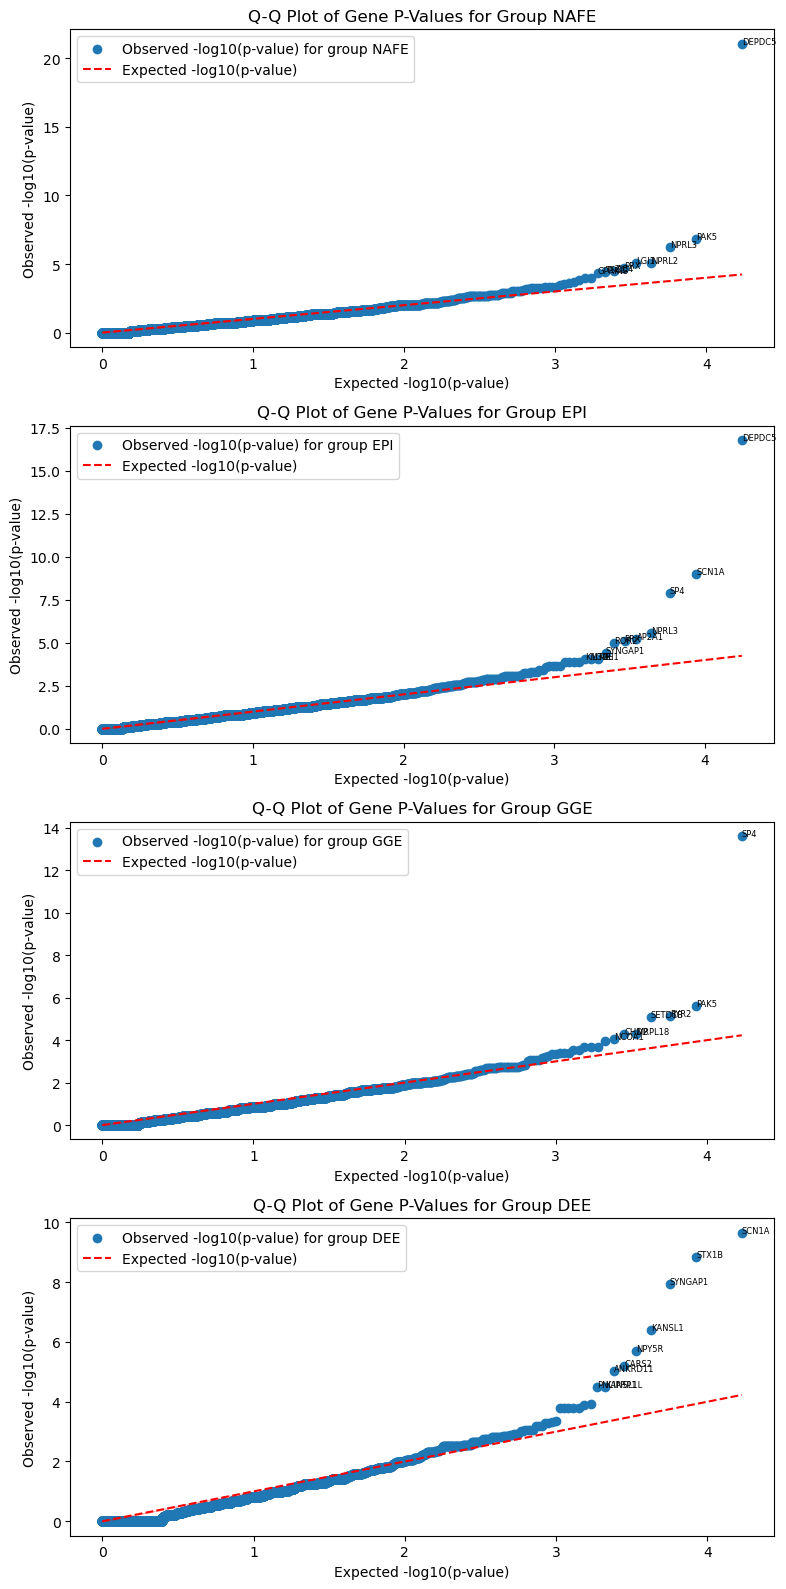

In [12]:
plot_group_QQ(pLoF_genes_df)

## Combine RGC constraint and Alpha Missense pathogenicity into meta regression model

In [9]:
# Subset to useful columns
constraint_predictions_df = constraint_predictions_df[['chr', 'pos', 'prob_0']]

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
max_am_pathogenicity_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# Filter for non-pLoF variants
non_pLoF_variants_df = variants_df[variants_df['consequence'] != "pLoF"]

# Subset to useful columns
non_pLoF_variants_df = non_pLoF_variants_df[['chr', 'pos', 'gene_id', 'gene_name', 'group', 'ac_case', 'an_case', 'ac_ctrl', 'an_ctrl']]

# Calculate effect size and variance
non_pLoF_variants_df = calculate_effect_size_and_variance(non_pLoF_variants_df)

# Merge constraint predictions, am_pathogenicity predictions, and non_pLoF variants based on chromosome and position
constraint_pathogenicity_non_pLoF_df = pd.merge(non_pLoF_variants_df, pd.merge(constraint_predictions_df, max_am_pathogenicity_df, on=['chr', 'pos'], how='inner'), on=['chr', 'pos'], how='inner')

# Write merged_df to a csv to repeat analysis in R
constraint_pathogenicity_non_pLoF_df.to_csv(results_path + f"constraint_am_epi25_non_pLoF.tsv.gz", index=False, compression='gzip', sep='\t')

constraint_pathogenicity_non_pLoF_df

,chr,pos,gene_id,gene_name,group,ac_case,an_case,ac_ctrl,an_ctrl,effect_size,var_effect_size,prob_0,am_pathogenicity
0,chr1,925946,ENSG00000187634,SAMD11,DEE,0,3876,1,66886,1.749437,2.666940,0.000050,0.9876
1,chr1,925946,ENSG00000187634,SAMD11,EPI,0,41956,1,66886,-0.632263,2.666705,0.000050,0.9876
2,chr1,925946,ENSG00000187634,SAMD11,GGE,0,10996,1,66886,0.706793,2.666773,0.000050,0.9876
3,chr1,925946,ENSG00000187634,SAMD11,NAFE,0,18438,1,66886,0.189929,2.666736,0.000050,0.9876
4,chr1,925948,ENSG00000187634,SAMD11,EPI,2,41958,0,66886,2.075802,2.400039,0.000040,0.9460
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8622956,chr22,50777959,ENSG00000079974,RABL2B,NAFE,0,18438,1,66888,0.189959,2.666736,0.391475,0.4255
8622957,chr22,50777974,ENSG00000079974,RABL2B,DEE,0,3876,1,66888,1.749467,2.666940,0.010142,0.9569
8622958,chr22,50777974,ENSG00000079974,RABL2B,EPI,0,41958,1,66888,-0.632281,2.666705,0.010142,0.9569
8622959,chr22,50777974,ENSG00000079974,RABL2B,GGE,0,10998,1,66888,0.706641,2.666773,0.010142,0.9569


In [15]:
# Read the data from the file
# constraint_pathogenicity_non_pLoF_df = pd.read_csv(results_path + f'constraint_am_epi25_non_pLoF.tsv.gz', sep='\t')

# Initialize lists to store results
meta_model_results = []

# Group data by gene_id, gene_name, and group
grouped_gene_data = constraint_pathogenicity_non_pLoF_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for gene_key, gene_data in tqdm(grouped_gene_data, desc="Processing genes", unit="gene"):
    gene_id, gene_name, group = gene_key
    
    # Meta-regression model for the gene
    X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
    y = gene_data['effect_size']
    weights = 1 / gene_data['var_effect_size']

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Append results to the list
        meta_model_results.append({
            'gene_id': gene_id,
            'gene_name': gene_name,
            'group': group,
            'p_constraint': model.pvalues['prob_0'],
            'p_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_const': model.pvalues['const'],
            'p_meta_model': model.f_pvalue
        })

    except:
        pass

# Create a DataFrame from the results
meta_model_results_df = pd.DataFrame(meta_model_results)

# Save the DataFrame to a compressed CSV file
# meta_model_results_df.to_csv(results_path + f"epi25_meta_model_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
meta_model_results_df

Processing genes:  99%|███████████████████████████████████████████████████████▍| 70918/71682 [04:48<00:03, 246.13gene/s]


,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model
0,ENSG00000000419,DPM1,DEE,0.967645,0.127074,1.334311e-11,0.304132
1,ENSG00000000419,DPM1,EPI,0.616641,0.896940,5.697050e-01,0.880110
2,ENSG00000000419,DPM1,GGE,0.933926,0.327129,6.237196e-04,0.597030
3,ENSG00000000419,DPM1,NAFE,0.618024,0.529452,8.498929e-02,0.748770
4,ENSG00000000457,SCYL3,DEE,0.931708,0.515902,9.323933e-44,0.790325
...,...,...,...,...,...,...,...
70751,ENSG00000285982,ENSG00000285982,NAFE,0.893494,0.968838,2.385042e-03,0.988895
70752,ENSG00000285991,ENSG00000285991,DEE,0.067215,0.013790,1.759947e-08,0.009251
70753,ENSG00000285991,ENSG00000285991,EPI,0.798659,0.852761,3.544924e-01,0.949486
70754,ENSG00000285991,ENSG00000285991,GGE,0.693358,0.636512,2.498023e-05,0.798587


## Join pLoF and meta regression results into unified model

In [16]:
# pLoF_genes_df = pd.read_csv(results_path + 'epi25_pLoF_pvalues.tsv.gz', sep='\t')
# meta_model_results_df = pd.read_csv(results_path + f'epi25_meta_model_pvalues.tsv.gz', sep='\t')

pLoF_results_df = pLoF_genes_df[['gene_id', 'gene_name', 'group', 'p_value']].rename({'p_value': 'p_pLoF'}, axis=1)

unified_model_df = pd.merge(meta_model_results_df, pLoF_results_df, on=['gene_id', 'gene_name', 'group'], how='outer')

unified_model_df['p_unified'] = unified_model_df.apply(lambda row: fisher_method(row['p_meta_model'], row['p_pLoF']), axis=1)

unified_model_df.to_csv(results_path + f"epi25_unified_model_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

unified_model_df

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model,p_pLoF,p_unified
0,ENSG00000000419,DPM1,DEE,0.967645,0.127074,1.334311e-11,0.304132,0.026846,0.047420
1,ENSG00000000419,DPM1,EPI,0.616641,0.896940,5.697050e-01,0.880110,0.001988,0.012859
2,ENSG00000000419,DPM1,GGE,0.933926,0.327129,6.237196e-04,0.597030,0.002161,0.009875
3,ENSG00000000419,DPM1,NAFE,0.618024,0.529452,8.498929e-02,0.748770,0.119622,0.305678
4,ENSG00000000457,SCYL3,DEE,0.931708,0.515902,9.323933e-44,0.790325,0.053851,0.176914
...,...,...,...,...,...,...,...,...,...
73716,ENSG00000234661,NaN,GGE,NaN,NaN,NaN,NaN,1.000000,1.000000
73717,ENSG00000174370,NaN,NAFE,NaN,NaN,NaN,NaN,1.000000,1.000000
73718,ENSG00000174370,NaN,GGE,NaN,NaN,NaN,NaN,1.000000,1.000000
73719,ENSG00000174370,NaN,EPI,NaN,NaN,NaN,NaN,1.000000,1.000000


## Analyze results of unified model

In [11]:
unified_model_df = pd.read_csv(results_path + f'epi25_unified_model_pvalues.tsv.gz', sep='\t')

filter_mask = (unified_model_df['p_unified'] < 1e-4) | (unified_model_df['p_constraint'] < 1e-4)
gene_name_mask = (unified_model_df['gene_name'] == 'CACNA1A')

pd.set_option('display.max_rows', 250)
unified_model_df[filter_mask].sort_values('p_unified')

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model,p_pLoF,p_unified
8113,ENSG00000100150,DEPDC5,NAFE,4.145678e-01,5.184659e-01,1.149651e-13,5.706123e-01,8.563275e-22,0.000000e+00
8111,ENSG00000100150,DEPDC5,EPI,4.421070e-01,8.127112e-01,6.986638e-03,7.305366e-01,1.624016e-17,4.440892e-16
50009,ENSG00000174021,GNG5,EPI,1.254063e-14,9.146462e-16,7.815991e-15,1.188567e-15,NaN,1.188567e-15
31675,ENSG00000144285,SCN1A,DEE,2.415990e-05,1.979039e-02,1.244264e-40,5.327486e-07,2.187209e-10,4.440892e-15
31676,ENSG00000144285,SCN1A,EPI,2.958731e-03,1.696500e-04,7.988012e-01,5.181989e-07,1.059414e-09,1.987299e-14
11628,ENSG00000105866,SP4,GGE,8.681799e-01,3.562524e-02,1.586623e-08,9.368811e-02,2.475126e-14,8.049117e-14
46949,ENSG00000170180,GYPA,NAFE,1.752792e-13,3.739913e-01,1.435007e-07,3.387542e-14,2.062093e-01,2.347011e-13
70407,ENSG00000284512,ENSG00000284512,NAFE,9.359565e-15,2.990376e-13,4.228407e-15,1.023495e-12,NaN,1.023495e-12
70406,ENSG00000284512,ENSG00000284512,GGE,9.521210e-14,3.894411e-12,4.317161e-14,3.900066e-11,NaN,3.900066e-11
70404,ENSG00000284512,ENSG00000284512,DEE,4.189192e-14,1.824583e-12,1.900997e-14,4.254750e-11,NaN,4.254750e-11


### Compare against published results

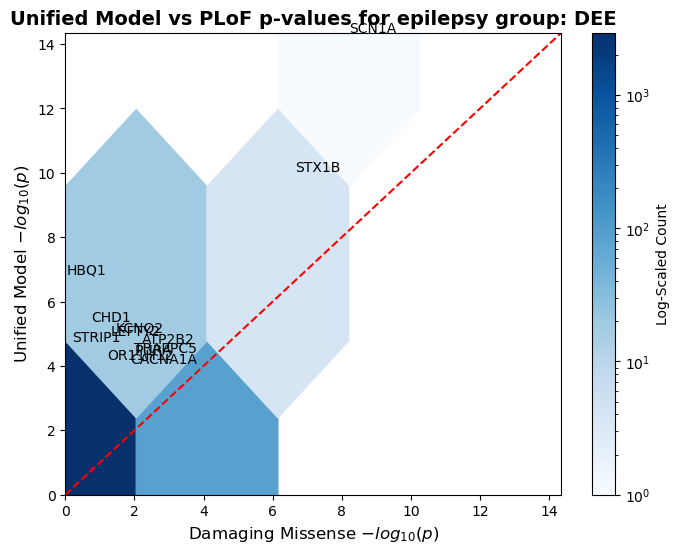

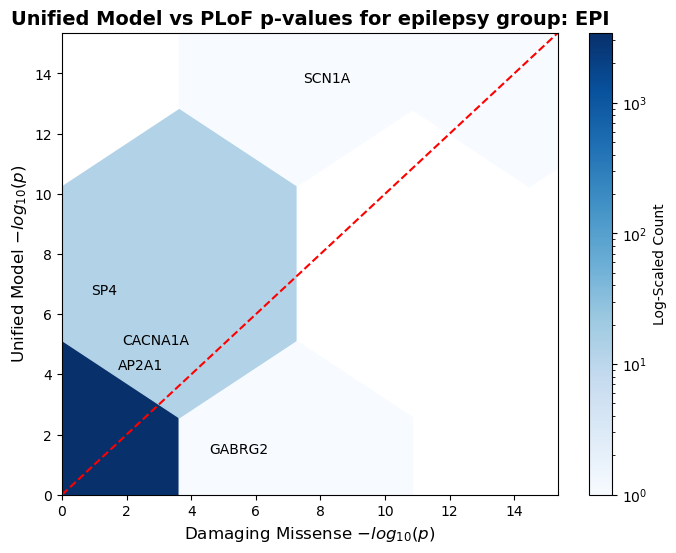

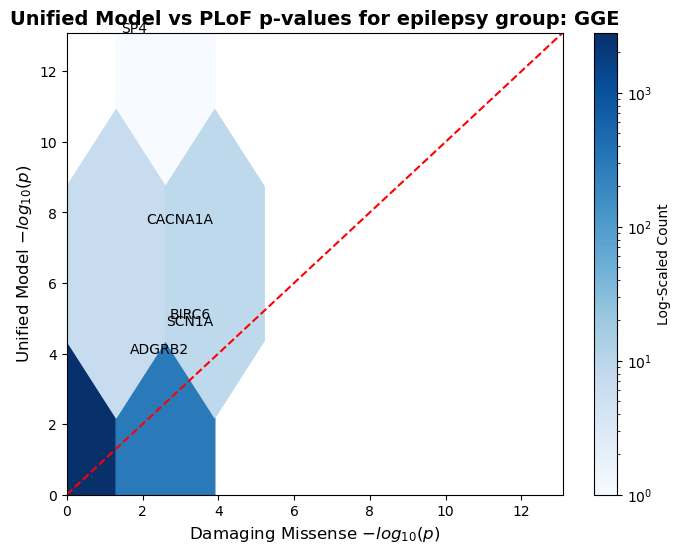

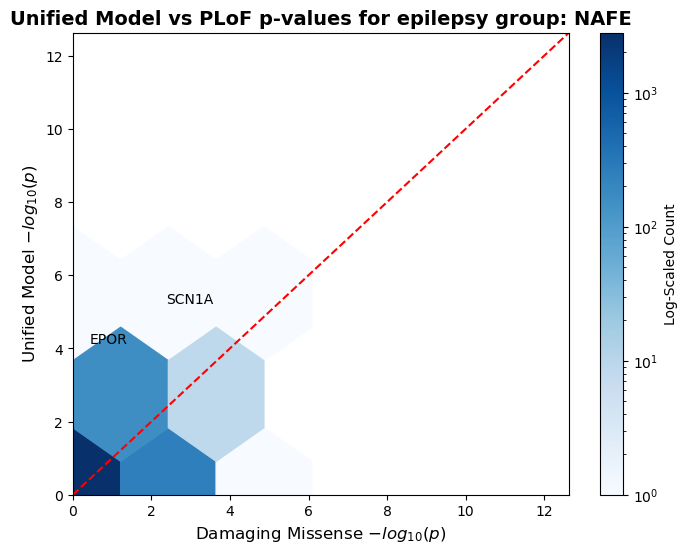

In [89]:
for group in unified_model_df['group'].unique():
    file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(unified_model_df[unified_model_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_unified'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(np.minimum(merged_pub_df['Damaging Missense p‑val'], merged_pub_df['PTV p‑val']))

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value

        # Create a hexbin (smoothscatter) plot with log scale
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points with larger fontsize
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=10)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title (bolded)
        plt.xlabel(r'Damaging Missense $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Unified Model vs PLoF p-values for epilepsy group: {group}', fontsize=14, fontweight="bold")

        # Show color bar
        plt.colorbar(label='Log-Scaled Count')

        plt.show()

    else:
        print(f"No files found for group {group}")

## Use negative log of constraint prob and pathogenicity prob as input variables

In [23]:
# Read the data from the file
constraint_pathogenicity_non_pLoF_df = pd.read_csv(results_path + f'constraint_am_epi25_non_pLoF.tsv.gz', sep='\t')

# Initialize lists to store results
log_meta_model_results = []

# Group data by gene_id, gene_name, and group
grouped_gene_data = constraint_pathogenicity_non_pLoF_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for gene_key, gene_data in tqdm(grouped_gene_data, desc="Processing genes", unit="gene"):
    gene_id, gene_name, group = gene_key
    
    # Meta-regression model for the gene
    X = sm.add_constant(-np.log(1-gene_data[['prob_0', 'am_pathogenicity']]))
    y = gene_data['effect_size']
    weights = 1 / gene_data['var_effect_size']

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()
        
        # Append results to the list
        log_meta_model_results.append({
            'gene_id': gene_id,
            'gene_name': gene_name,
            'group': group,
            'p_constraint': model.pvalues['prob_0'],
            'p_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_const': model.pvalues['const'],
            'p_meta_model': model.f_pvalue
        })

    except:
        pass

# Create a DataFrame from the results
log_meta_model_results_df = pd.DataFrame(log_meta_model_results)

# Save the DataFrame to a compressed CSV file
log_meta_model_results_df.to_csv(results_path + f"epi25_log_meta_model_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
log_meta_model_results_df

Processing genes:  99%|███████████████████████████████████████████████████████▍| 70918/71682 [06:20<00:04, 186.43gene/s]


,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model
0,ENSG00000000419,DPM1,DEE,0.936503,0.268218,1.579218e-16,0.530954
1,ENSG00000000419,DPM1,EPI,0.471313,0.928074,3.839965e-01,0.769864
2,ENSG00000000419,DPM1,GGE,0.959984,0.388418,2.407338e-06,0.685471
3,ENSG00000000419,DPM1,NAFE,0.591151,0.655710,8.503934e-03,0.794378
4,ENSG00000000457,SCYL3,DEE,0.869751,0.931777,2.723517e-52,0.985798
...,...,...,...,...,...,...,...
69446,ENSG00000285982,ENSG00000285982,NAFE,0.892642,0.817256,4.480943e-05,0.959762
69447,ENSG00000285991,ENSG00000285991,DEE,0.009737,0.014752,2.634610e-12,0.002721
69448,ENSG00000285991,ENSG00000285991,EPI,0.557667,0.961258,1.695844e-01,0.839989
69449,ENSG00000285991,ENSG00000285991,GGE,0.694397,0.562096,3.861340e-07,0.751356


In [18]:
# pLoF_genes_df = pd.read_csv(results_path + 'epi25_pLoF_pvalues.tsv.gz', sep='\t')
log_meta_model_results_df = pd.read_csv(results_path + f'epi25_log_meta_model_pvalues.tsv.gz', sep='\t')

pLoF_results_df = pLoF_genes_df[['gene_id', 'gene_name', 'group', 'p_value']].rename({'p_value': 'p_pLoF'}, axis=1)

log_unified_model_df = pd.merge(log_meta_model_results_df, pLoF_results_df, on=['gene_id', 'gene_name', 'group'], how='outer')

log_unified_model_df['p_unified'] = log_unified_model_df.apply(lambda row: fisher_method(row['p_meta_model'], row['p_pLoF']), axis=1)

log_unified_model_df

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model,p_pLoF,p_unified
0,ENSG00000000419,DPM1,DEE,0.936503,0.268218,1.579218e-16,0.530954,0.026846,0.074843
1,ENSG00000000419,DPM1,EPI,0.471313,0.928074,3.839965e-01,0.769864,0.001988,0.011453
2,ENSG00000000419,DPM1,GGE,0.959984,0.388418,2.407338e-06,0.685471,0.002161,0.011134
3,ENSG00000000419,DPM1,NAFE,0.591151,0.655710,8.503934e-03,0.794378,0.119622,0.318678
4,ENSG00000000457,SCYL3,DEE,0.869751,0.931777,2.723517e-52,0.985798,0.053851,0.208938
...,...,...,...,...,...,...,...,...,...
73500,ENSG00000234661,NaN,GGE,NaN,NaN,NaN,NaN,1.000000,1.000000
73501,ENSG00000174370,NaN,NAFE,NaN,NaN,NaN,NaN,1.000000,1.000000
73502,ENSG00000174370,NaN,GGE,NaN,NaN,NaN,NaN,1.000000,1.000000
73503,ENSG00000174370,NaN,EPI,NaN,NaN,NaN,NaN,1.000000,1.000000


In [93]:
filter_mask = (log_unified_model_df['p_unified'] < 1e-4) | (log_unified_model_df['p_constraint'] < 1e-4)
gene_name_mask = (log_unified_model_df['gene_name'] == 'CACNA1A')

pd.set_option('display.max_rows', 250)
log_unified_model_df[filter_mask].sort_values('p_unified')

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model,p_pLoF,p_unified
30957,ENSG00000144285,SCN1A,DEE,3.346591e-04,1.633587e-06,1.850774e-68,2.194320e-11,2.187209e-10,0.000000e+00
7929,ENSG00000100150,DEPDC5,NAFE,5.752043e-01,4.296857e-01,1.600545e-22,6.148800e-01,8.563275e-22,0.000000e+00
30958,ENSG00000144285,SCN1A,EPI,3.437584e-02,1.339256e-06,2.745315e-02,1.056246e-08,1.059414e-09,4.440892e-16
7927,ENSG00000100150,DEPDC5,EPI,3.587373e-01,9.872971e-01,5.304403e-04,6.549214e-01,1.624016e-17,4.440892e-16
45981,ENSG00000170180,GYPA,NAFE,3.601940e-15,5.025501e-01,1.039304e-10,2.382655e-16,2.062093e-01,1.887379e-15
48981,ENSG00000174021,GNG5,EPI,1.438316e-14,3.080664e-15,9.399559e-15,4.009197e-15,NaN,4.009197e-15
11352,ENSG00000105866,SP4,GGE,7.666964e-01,1.110814e-01,2.670030e-23,2.797198e-01,2.475126e-14,2.327027e-13
69105,ENSG00000284512,ENSG00000284512,NAFE,2.978702e-15,4.903302e-12,2.576993e-15,5.590318e-12,NaN,5.590318e-12
26432,ENSG00000136854,STXBP1,DEE,5.699085e-02,5.715391e-09,1.554881e-11,2.043769e-09,1.642088e-04,9.975132e-12
69104,ENSG00000284512,ENSG00000284512,GGE,1.860900e-15,8.545154e-12,1.610027e-15,1.300022e-11,NaN,1.300022e-11


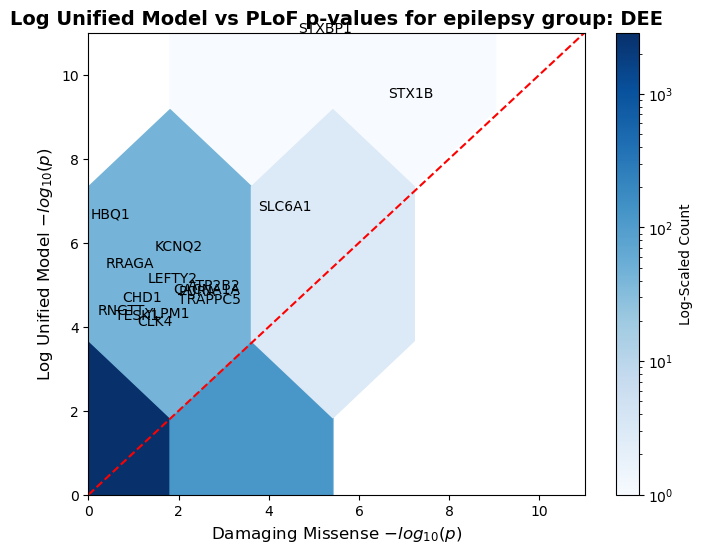

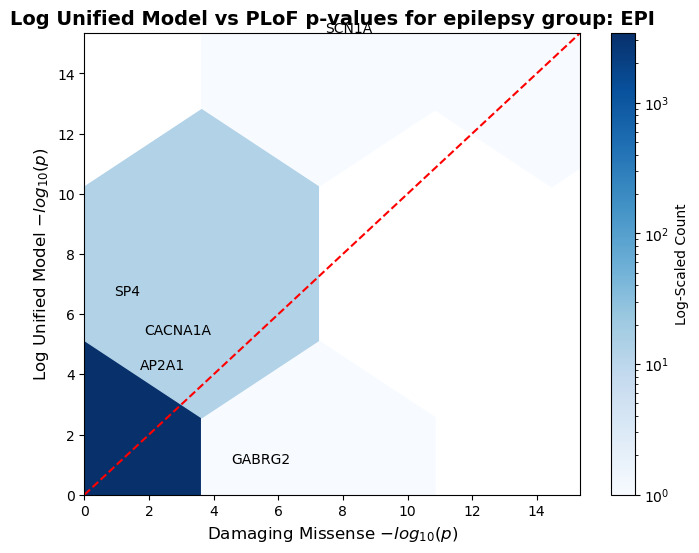

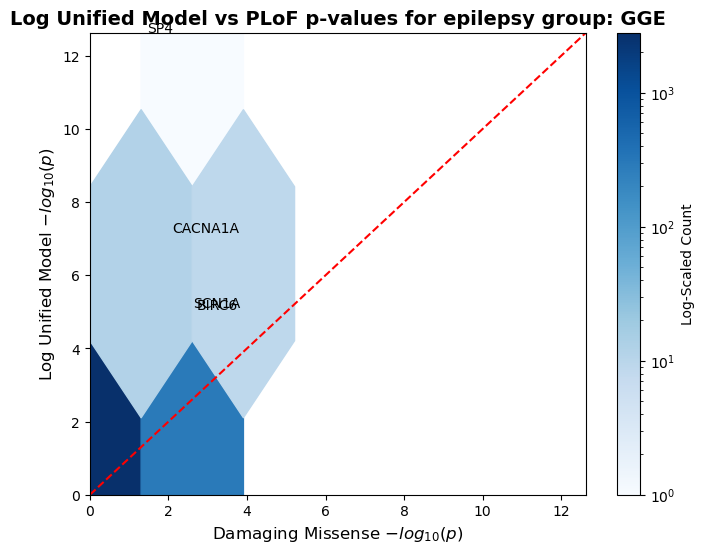

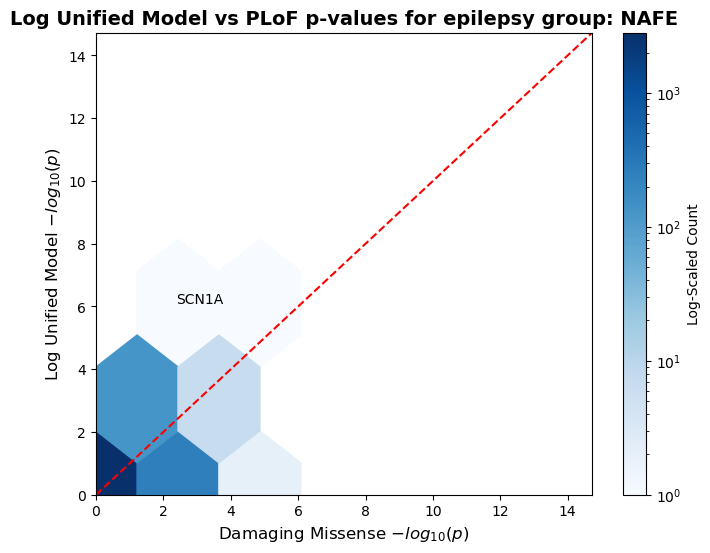

In [94]:
for group in log_unified_model_df['group'].unique():
    file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(log_unified_model_df[log_unified_model_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_unified'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(np.minimum(merged_pub_df['Damaging Missense p‑val'], merged_pub_df['PTV p‑val']))

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value

        # Create a hexbin (smoothscatter) plot with log scale
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points with larger fontsize
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=10)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title (bolded)
        plt.xlabel(r'Damaging Missense $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Log Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Log Unified Model vs PLoF p-values for epilepsy group: {group}', fontsize=14, fontweight="bold")

        # Show color bar
        plt.colorbar(label='Log-Scaled Count')

        plt.show()

    else:
        print(f"No files found for group {group}")

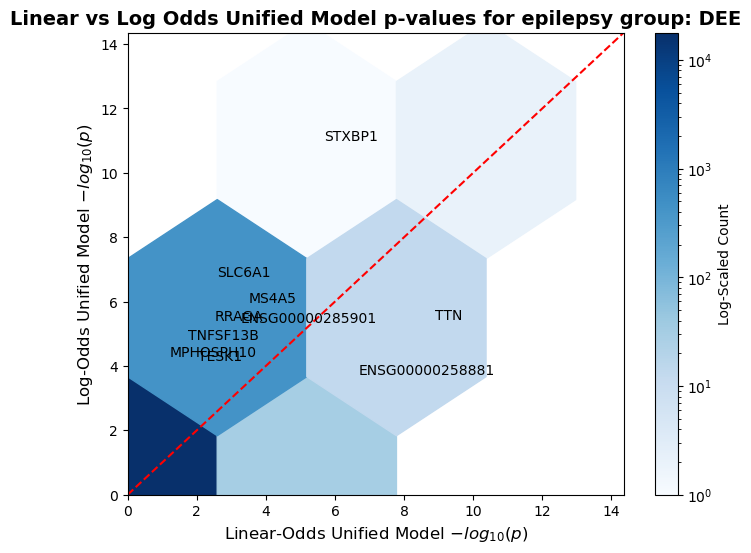

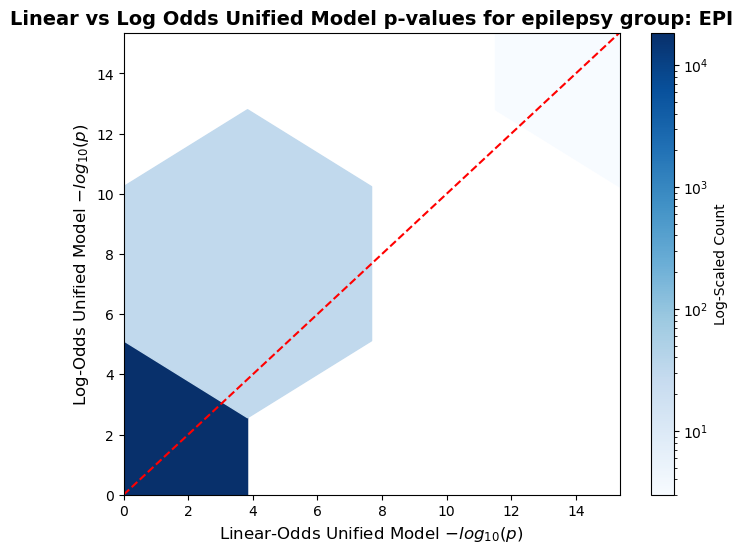

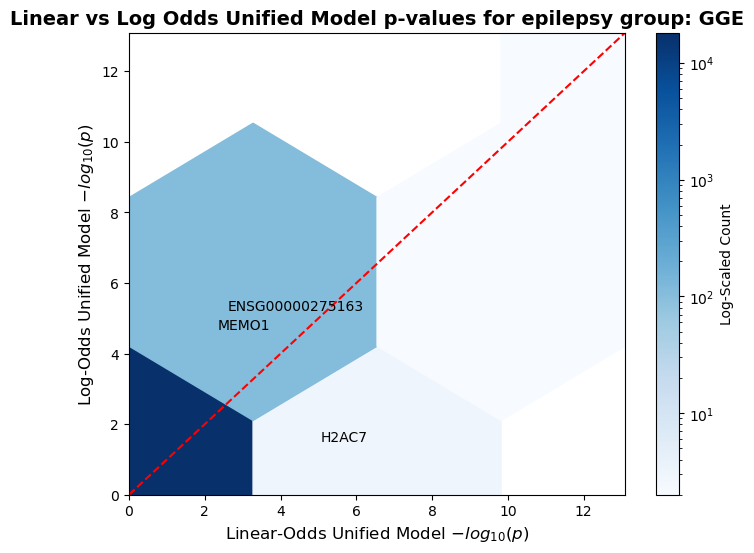

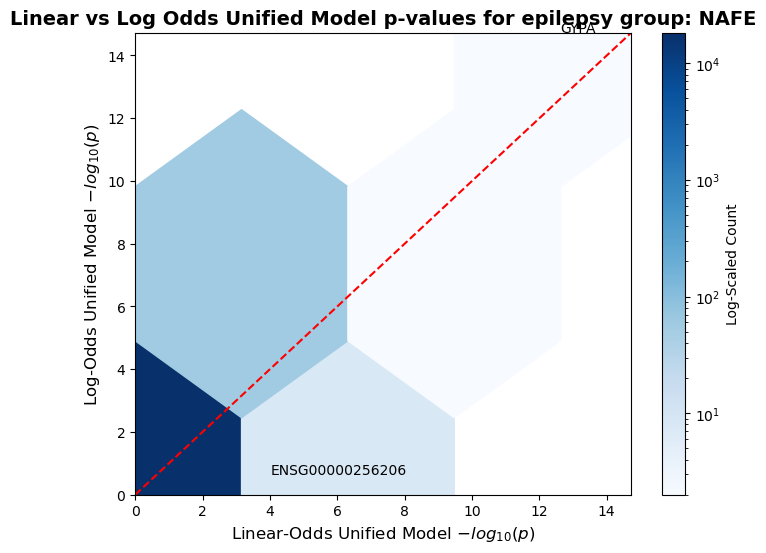

In [95]:
for group in unified_model_df['group'].unique():
    file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(unified_model_df[unified_model_df['group'] == group], log_unified_model_df[log_unified_model_df['group'] == group], on=['gene_id', 'gene_name', 'group'], suffixes=('_linear', '_log'))

        merged_pub_df['minus_log_pval_linear'] = -np.log10(merged_pub_df['p_unified_linear'])
        merged_pub_df['minus_log_pval_log'] = -np.log10(merged_pub_df['p_unified_log'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_pval_linear'].min(), merged_pub_df['minus_log_pval_log'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_pval_linear'].max(), merged_pub_df['minus_log_pval_log'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value

        # Create a hexbin (smoothscatter) plot with log scale
        plt.hexbin(merged_pub_df['minus_log_pval_linear'], merged_pub_df['minus_log_pval_log'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points with larger fontsize
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_pval_linear'] - row['minus_log_pval_log'])) > 2) & (max(row['minus_log_pval_linear'], row['minus_log_pval_log']) > 4):
                plt.text(row['minus_log_pval_linear'], row['minus_log_pval_log'], row['gene_name'], fontsize=10)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title (bolded)
        plt.xlabel(r'Linear-Odds Unified Model $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Log-Odds Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Linear vs Log Odds Unified Model p-values for epilepsy group: {group}', fontsize=14, fontweight="bold")

        # Show color bar
        plt.colorbar(label='Log-Scaled Count')

        plt.show()

    else:
        print(f"No files found for group {group}")

## Use log-odds of constraint prob and pathogenicity prob as input variables

In [14]:
# Read the data from the file
constraint_pathogenicity_non_pLoF_df = pd.read_csv(results_path + f'constraint_am_epi25_non_pLoF.tsv.gz', sep='\t')

# Initialize lists to store results
log_odds_meta_model_results = []

# Group data by gene_id, gene_name, and group
grouped_gene_data = constraint_pathogenicity_non_pLoF_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for gene_key, gene_data in tqdm(grouped_gene_data, desc="Processing genes", unit="gene"):
    gene_id, gene_name, group = gene_key
    
    # Meta-regression model for the gene
    # TODO: Rerun this
    X = sm.add_constant(-np.log((1-gene_data[['prob_0', 'am_pathogenicity']])/gene_data[['prob_0', 'am_pathogenicity']]))
    y = gene_data['effect_size']
    weights = 1 / gene_data['var_effect_size']

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()
        
        # Append results to the list
        log_odds_meta_model_results.append({
            'gene_id': gene_id,
            'gene_name': gene_name,
            'group': group,
            'p_constraint': model.pvalues['prob_0'],
            'p_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_const': model.pvalues['const'],
            'p_meta_model': model.f_pvalue
        })

    except:
        pass

# Create a DataFrame from the results
log_odds_meta_model_results_df = pd.DataFrame(log_odds_meta_model_results)

# Save the DataFrame to a compressed CSV file
log_odds_meta_model_results_df.to_csv(results_path + f"epi25_log_odds_meta_model_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
log_odds_meta_model_results_df

Processing genes:  99%|███████████████████████████████████████████████████████▍| 70918/71682 [07:32<00:04, 156.65gene/s]


,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model
0,ENSG00000000419,DPM1,DEE,0.897274,0.237414,6.000751e-09,0.441311
1,ENSG00000000419,DPM1,EPI,0.874284,0.960562,5.532828e-01,0.987420
2,ENSG00000000419,DPM1,GGE,0.935745,0.395054,4.858414e-03,0.678731
3,ENSG00000000419,DPM1,NAFE,0.544573,0.704417,4.016984e-02,0.730982
4,ENSG00000000457,SCYL3,DEE,0.247954,0.678137,4.390831e-27,0.460890
...,...,...,...,...,...,...,...
69446,ENSG00000285982,ENSG00000285982,NAFE,0.788081,0.781479,7.855868e-03,0.937130
69447,ENSG00000285991,ENSG00000285991,DEE,0.058751,0.035674,6.691200e-13,0.008618
69448,ENSG00000285991,ENSG00000285991,EPI,0.632603,0.793915,1.731037e-01,0.842983
69449,ENSG00000285991,ENSG00000285991,GGE,0.728513,0.791957,1.444005e-02,0.885822


In [15]:
# pLoF_genes_df = pd.read_csv(results_path + 'epi25_pLoF_pvalues.tsv.gz', sep='\t')
log_odds_meta_model_results_df = pd.read_csv(results_path + f'epi25_log_odds_meta_model_pvalues.tsv.gz', sep='\t')

pLoF_results_df = pLoF_genes_df[['gene_id', 'gene_name', 'group', 'p_value']].rename({'p_value': 'p_pLoF'}, axis=1)

log_odds_unified_model_df = pd.merge(log_odds_meta_model_results_df, pLoF_results_df, on=['gene_id', 'gene_name', 'group'], how='outer')

log_odds_unified_model_df['p_unified'] = log_odds_unified_model_df.apply(lambda row: fisher_method(row['p_meta_model'], row['p_pLoF']), axis=1)

log_odds_unified_model_df

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model,p_pLoF,p_unified
0,ENSG00000000419,DPM1,DEE,0.897274,0.237414,6.000751e-09,0.441311,0.026846,0.064398
1,ENSG00000000419,DPM1,EPI,0.874284,0.960562,5.532828e-01,0.987420,0.001988,0.014201
2,ENSG00000000419,DPM1,GGE,0.935745,0.395054,4.858414e-03,0.678731,0.002161,0.011039
3,ENSG00000000419,DPM1,NAFE,0.544573,0.704417,4.016984e-02,0.730982,0.119622,0.300518
4,ENSG00000000457,SCYL3,DEE,0.247954,0.678137,4.390831e-27,0.460890,0.053851,0.116555
...,...,...,...,...,...,...,...,...,...
73500,ENSG00000234661,NaN,GGE,NaN,NaN,NaN,NaN,1.000000,1.000000
73501,ENSG00000174370,NaN,NAFE,NaN,NaN,NaN,NaN,1.000000,1.000000
73502,ENSG00000174370,NaN,GGE,NaN,NaN,NaN,NaN,1.000000,1.000000
73503,ENSG00000174370,NaN,EPI,NaN,NaN,NaN,NaN,1.000000,1.000000


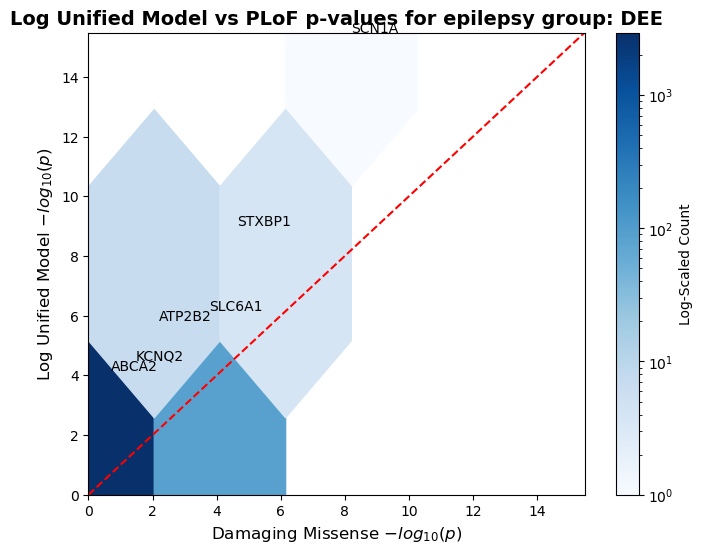

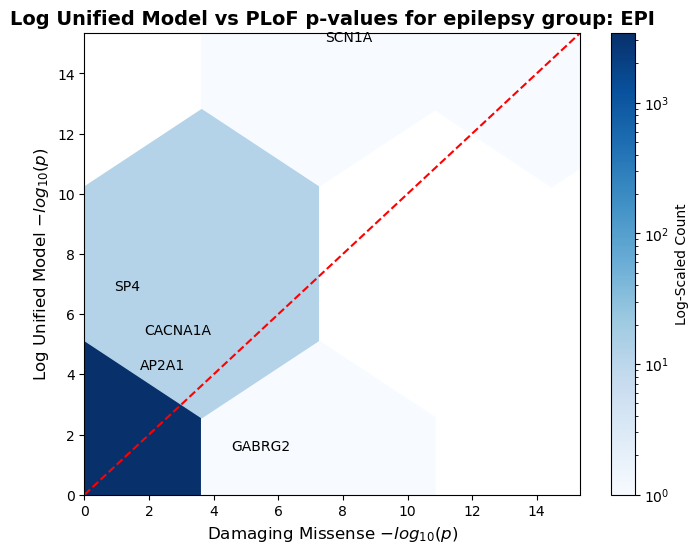

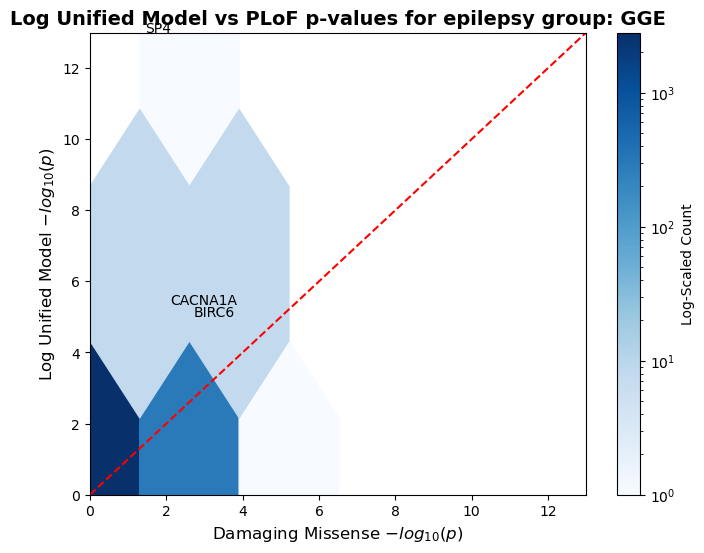

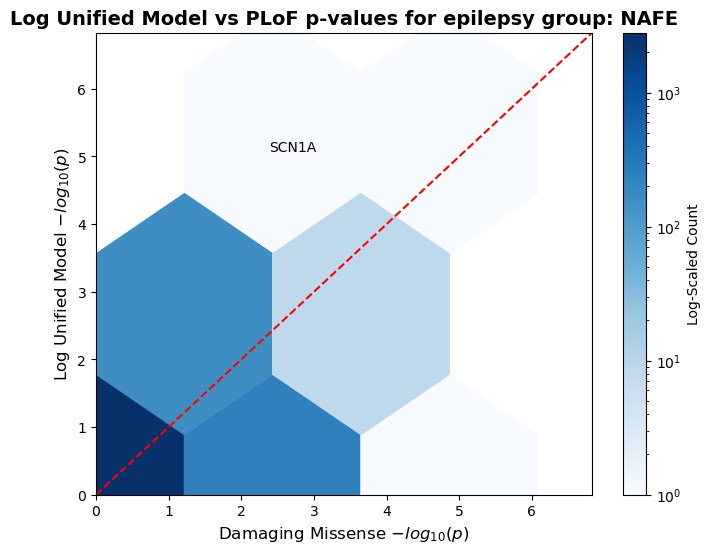

In [16]:
for group in log_odds_unified_model_df['group'].unique():
    file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(log_odds_unified_model_df[log_odds_unified_model_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_unified'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(np.minimum(merged_pub_df['Damaging Missense p‑val'], merged_pub_df['PTV p‑val']))

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value

        # Create a hexbin (smoothscatter) plot with log scale
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points with larger fontsize
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=10)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title (bolded)
        plt.xlabel(r'Damaging Missense $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Log Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Log Unified Model vs PLoF p-values for epilepsy group: {group}', fontsize=14, fontweight="bold")

        # Show color bar
        plt.colorbar(label='Log-Scaled Count')

        plt.show()

    else:
        print(f"No files found for group {group}")

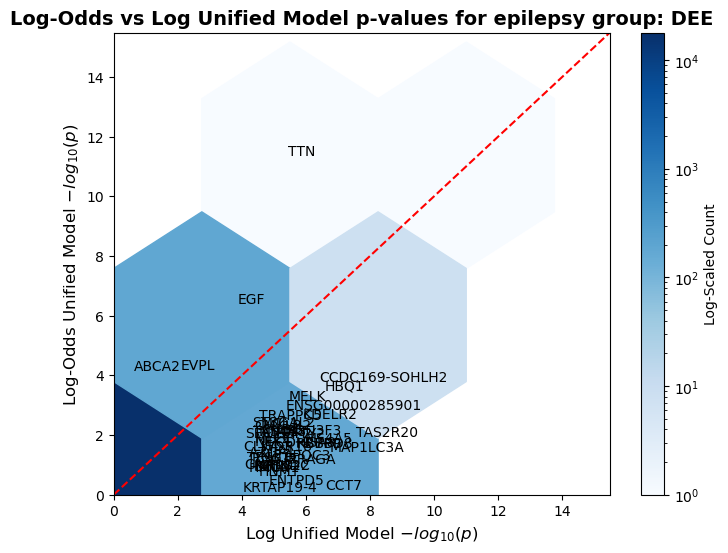

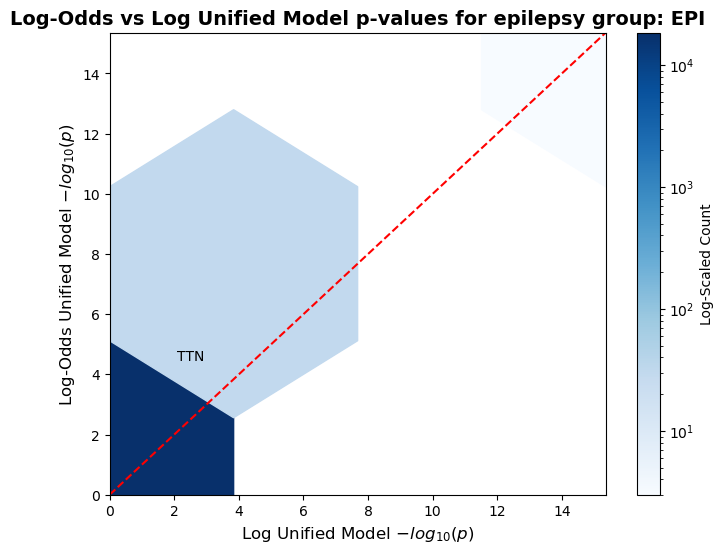

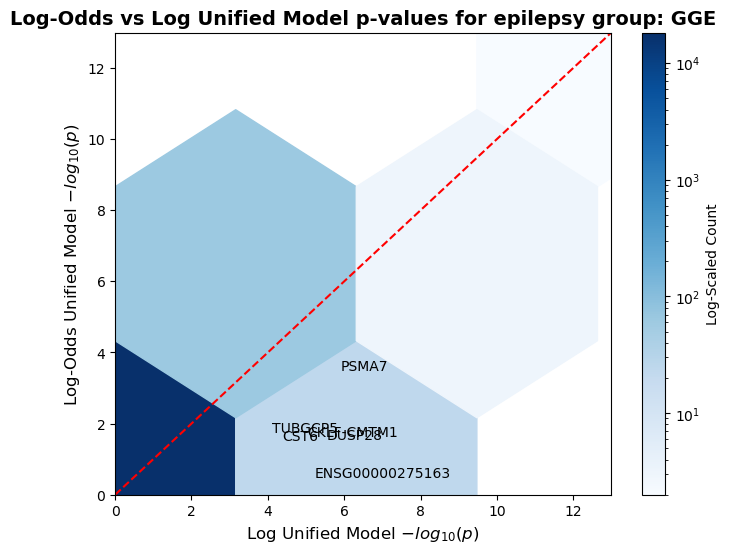

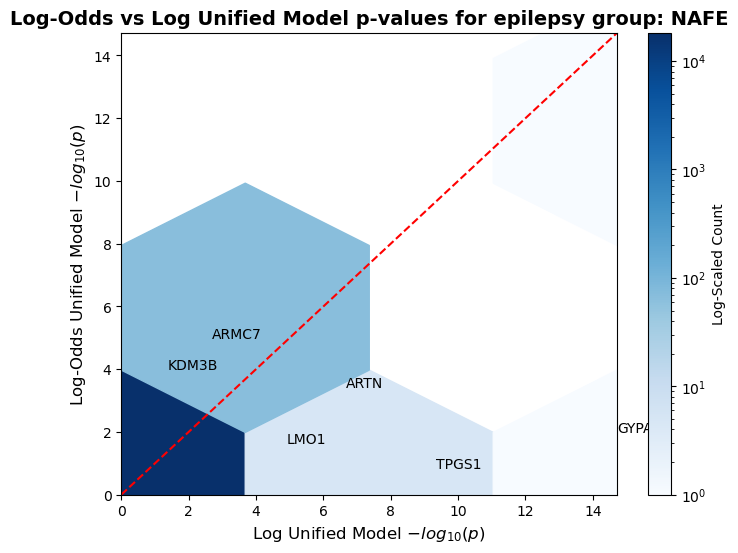

In [20]:
for group in log_unified_model_df['group'].unique():
    file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(log_unified_model_df[log_unified_model_df['group'] == group], log_odds_unified_model_df[log_odds_unified_model_df['group'] == group], on=['gene_id', 'gene_name', 'group'], suffixes=('_log', '_log_odds'))

        merged_pub_df['minus_log_pval_log'] = -np.log10(merged_pub_df['p_unified_log'])
        merged_pub_df['minus_log_pval_log_odds'] = -np.log10(merged_pub_df['p_unified_log_odds'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_pval_log'].min(), merged_pub_df['minus_log_pval_log_odds'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_pval_log'].max(), merged_pub_df['minus_log_pval_log_odds'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value

        # Create a hexbin (smoothscatter) plot with log scale
        plt.hexbin(merged_pub_df['minus_log_pval_log'], merged_pub_df['minus_log_pval_log_odds'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points with larger fontsize
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_pval_log'] - row['minus_log_pval_log_odds'])) > 2) & (max(row['minus_log_pval_log'], row['minus_log_pval_log_odds']) > 4):
                plt.text(row['minus_log_pval_log'], row['minus_log_pval_log_odds'], row['gene_name'], fontsize=10)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title (bolded)
        plt.xlabel(r'Log Unified Model $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Log-Odds Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Log-Odds vs Log Unified Model p-values for epilepsy group: {group}', fontsize=14, fontweight="bold")

        # Show color bar
        plt.colorbar(label='Log-Scaled Count')

        plt.show()

    else:
        print(f"No files found for group {group}")

## Add pLoF indicator as input variable

In [19]:
# Subset to useful columns
constraint_predictions_df = constraint_predictions_df[['chr', 'pos', 'prob_0']]

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
max_am_pathogenicity_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# copy variants df
pLoF_ind_variants_df = variants_df

# Create indicator column for pLoF variants
pLoF_ind_variants_df['pLoF_ind'] = (variants_df['consequence'] == "pLoF").astype('int32')

# Subset to useful columns
pLoF_ind_variants_df = pLoF_ind_variants_df[['chr', 'pos', 'gene_id', 'gene_name', 'group', 'ac_case', 'an_case', 'ac_ctrl', 'an_ctrl', 'pLoF_ind']]

# Calculate effect size and variance
pLoF_ind_variants_df = calculate_effect_size_and_variance(pLoF_ind_variants_df)

# Merge constraint predictions, am_pathogenicity predictions, and non_pLoF variants based on chromosome and position
constraint_pathogenicity_pLoF_ind_df = pd.merge(pLoF_ind_variants_df, pd.merge(constraint_predictions_df, max_am_pathogenicity_df, on=['chr', 'pos'], how='inner'), on=['chr', 'pos'], how='inner')

# Write merged_df to a csv to repeat analysis in R
# constraint_pathogenicity_pLoF_ind_df.to_csv(results_path + f"constraint_am_epi25_pLoF_ind.tsv.gz", index=False, compression='gzip', sep='\t')

constraint_pathogenicity_pLoF_ind_df

,chr,pos,gene_id,gene_name,group,ac_case,an_case,ac_ctrl,an_ctrl,pLoF_ind,effect_size,var_effect_size,prob_0,am_pathogenicity
0,chr1,925946,ENSG00000187634,SAMD11,DEE,0,3876,1,66886,0,1.749437,2.666940,0.000050,0.9876
1,chr1,925946,ENSG00000187634,SAMD11,EPI,0,41956,1,66886,0,-0.632263,2.666705,0.000050,0.9876
2,chr1,925946,ENSG00000187634,SAMD11,GGE,0,10996,1,66886,0,0.706793,2.666773,0.000050,0.9876
3,chr1,925946,ENSG00000187634,SAMD11,NAFE,0,18438,1,66886,0,0.189929,2.666736,0.000050,0.9876
4,chr1,925948,ENSG00000187634,SAMD11,EPI,2,41958,0,66886,0,2.075802,2.400039,0.000040,0.9460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9142394,chr22,50777959,ENSG00000079974,RABL2B,NAFE,0,18438,1,66888,0,0.189959,2.666736,0.391475,0.4255
9142395,chr22,50777974,ENSG00000079974,RABL2B,DEE,0,3876,1,66888,0,1.749467,2.666940,0.010142,0.9569
9142396,chr22,50777974,ENSG00000079974,RABL2B,EPI,0,41958,1,66888,0,-0.632281,2.666705,0.010142,0.9569
9142397,chr22,50777974,ENSG00000079974,RABL2B,GGE,0,10998,1,66888,0,0.706641,2.666773,0.010142,0.9569


In [26]:
# Read the data from the file
# constraint_pathogenicity_pLoF_ind_df = pd.read_csv(results_path + f'constraint_am_epi25_pLoF_ind.tsv.gz', sep='\t')

# Initialize lists to store results
meta_model_results = []

input_df = constraint_pathogenicity_pLoF_ind_df
input_df[['log_constraint', 'log_pathogenicity']] = -np.log(1-input_df[['prob_0', 'am_pathogenicity']])

# Group data by gene_id, gene_name, and group
grouped_gene_data = input_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for gene_key, gene_data in tqdm(grouped_gene_data, desc="Processing genes", unit="gene"):
    gene_id, gene_name, group = gene_key
    
    # Meta-regression model for the gene
    X = sm.add_constant(gene_data[['log_constraint', 'log_pathogenicity', 'pLoF_ind']])
    y = gene_data['effect_size']
    weights = 1 / gene_data['var_effect_size']

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()
        
        # Append results to the list
        meta_model_results.append({
            'gene_id': gene_id,
            'gene_name': gene_name,
            'group': group,
            'p_constraint': model.pvalues['log_constraint'],
            'p_pathogenicity': model.pvalues['log_pathogenicity'],
            'p_pLoF': model.pvalues['pLoF_ind'],
            'p_const': model.pvalues['const'],
            'p_unified': model.f_pvalue
        })

    except:
        pass

# Create a DataFrame from the results
meta_model_results_df = pd.DataFrame(meta_model_results)

# Save the DataFrame to a compressed CSV file
meta_model_results_df.to_csv(results_path + f"epi25_ind_meta_model_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
meta_model_results_df

Processing genes:  98%|███████████████████████████████████████████████████████ | 70971/72250 [06:50<00:07, 172.71gene/s]


,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_pLoF,p_const,p_unified
0,ENSG00000000419,DPM1,DEE,0.921666,0.427682,0.032662,2.749732e-16,0.145844
1,ENSG00000000419,DPM1,EPI,0.452711,0.928062,0.001000,3.518679e-01,0.006660
2,ENSG00000000419,DPM1,GGE,0.969067,0.420388,0.003825,1.149988e-06,0.020369
3,ENSG00000000419,DPM1,NAFE,0.605102,0.722610,0.007375,7.121449e-03,0.042602
4,ENSG00000000457,SCYL3,DEE,0.566119,0.777875,0.028370,2.860911e-52,0.153311
...,...,...,...,...,...,...,...,...
69381,ENSG00000285982,ENSG00000285982,NAFE,0.377649,0.525788,0.840229,1.367607e-06,0.643573
69382,ENSG00000285991,ENSG00000285991,DEE,0.009737,0.014752,NaN,2.634610e-12,0.002721
69383,ENSG00000285991,ENSG00000285991,EPI,0.557667,0.961258,NaN,1.695844e-01,0.839989
69384,ENSG00000285991,ENSG00000285991,GGE,0.694397,0.562096,NaN,3.861340e-07,0.751356


In [27]:
# pLoF_genes_df = pd.read_csv(results_path + 'epi25_pLoF_pvalues.tsv.gz', sep='\t')
# meta_model_results_df = pd.read_csv(results_path + f'epi25_ind_meta_model_pvalues.tsv.gz', sep='\t')

# pLoF_results_df = pLoF_genes_df[['gene_id', 'gene_name', 'group', 'p_value']].rename({'p_value': 'p_pLoF'}, axis=1)

# unified_model_df = pd.merge(meta_model_results_df, pLoF_results_df, on=['gene_id', 'gene_name', 'group'], how='outer')

# unified_model_df['p_unified'] = unified_model_df.apply(lambda row: fisher_method(row['p_meta_model'], row['p_pLoF']), axis=1)

unified_model_df = meta_model_results_df

unified_model_df

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_pLoF,p_const,p_unified
0,ENSG00000000419,DPM1,DEE,0.921666,0.427682,0.032662,2.749732e-16,0.145844
1,ENSG00000000419,DPM1,EPI,0.452711,0.928062,0.001000,3.518679e-01,0.006660
2,ENSG00000000419,DPM1,GGE,0.969067,0.420388,0.003825,1.149988e-06,0.020369
3,ENSG00000000419,DPM1,NAFE,0.605102,0.722610,0.007375,7.121449e-03,0.042602
4,ENSG00000000457,SCYL3,DEE,0.566119,0.777875,0.028370,2.860911e-52,0.153311
...,...,...,...,...,...,...,...,...
69381,ENSG00000285982,ENSG00000285982,NAFE,0.377649,0.525788,0.840229,1.367607e-06,0.643573
69382,ENSG00000285991,ENSG00000285991,DEE,0.009737,0.014752,NaN,2.634610e-12,0.002721
69383,ENSG00000285991,ENSG00000285991,EPI,0.557667,0.961258,NaN,1.695844e-01,0.839989
69384,ENSG00000285991,ENSG00000285991,GGE,0.694397,0.562096,NaN,3.861340e-07,0.751356


In [36]:
filter_mask = (unified_model_df['p_unified'] < 1e-4) | (unified_model_df['p_constraint'] < 1e-4)
gene_name_mask = (unified_model_df['gene_name'] == 'TXNL4A')

pd.set_option('display.max_rows', 250)
unified_model_df[gene_name_mask].sort_values('p_unified')

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_pLoF,p_const,p_unified
29536,ENSG00000141759,TXNL4A,EPI,0.051531,0.018416,0.024224,0.152170,0.051083
29538,ENSG00000141759,TXNL4A,NAFE,0.055952,0.045154,0.023983,0.028776,0.084723
29535,ENSG00000141759,TXNL4A,DEE,0.117114,0.415257,0.125662,0.005724,0.368141
29537,ENSG00000141759,TXNL4A,GGE,0.118761,0.421901,0.129603,0.158426,0.374179


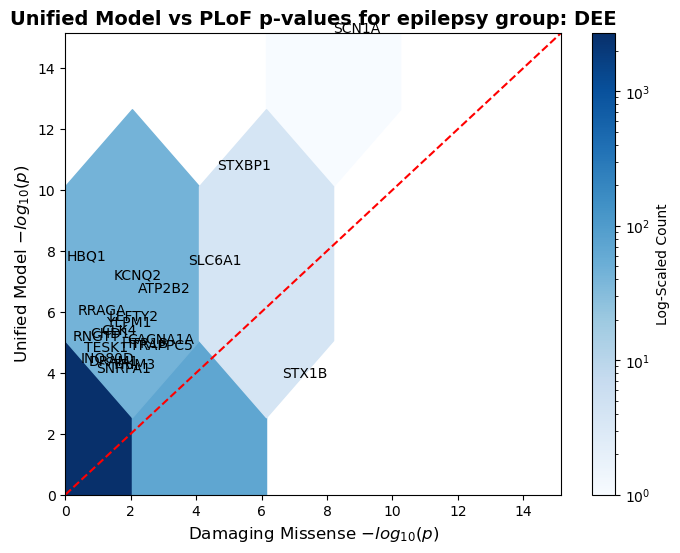

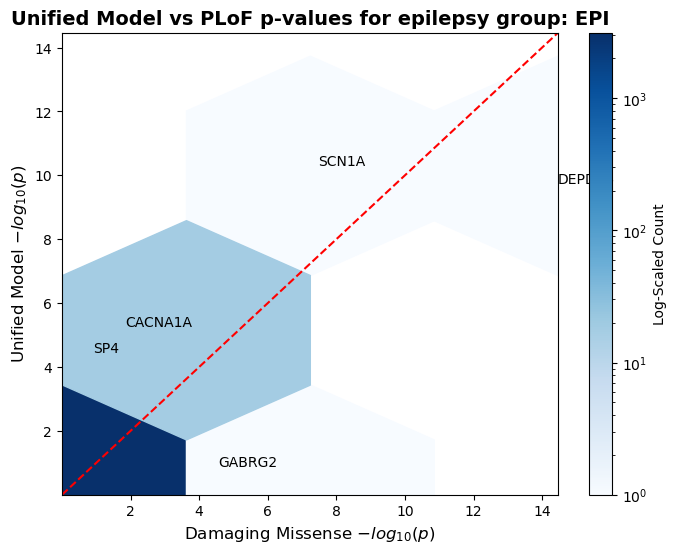

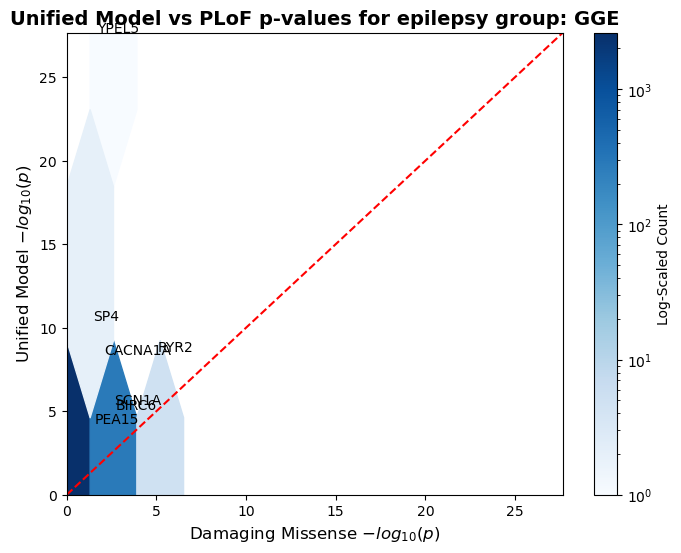

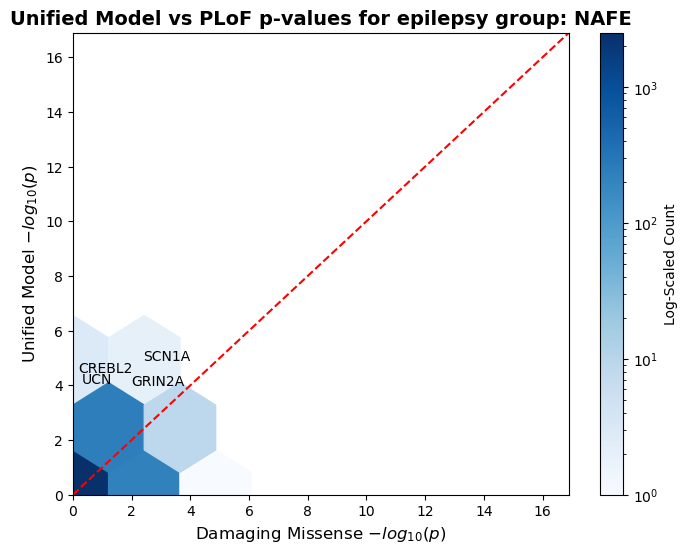

In [24]:
for group in unified_model_df['group'].unique():
    file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(unified_model_df[unified_model_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_unified'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(np.minimum(merged_pub_df['Damaging Missense p‑val'], merged_pub_df['PTV p‑val']))

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value

        # Create a hexbin (smoothscatter) plot with log scale
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points with larger fontsize
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=10)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title (bolded)
        plt.xlabel(r'Damaging Missense $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Unified Model vs PLoF p-values for epilepsy group: {group}', fontsize=14, fontweight="bold")

        # Show color bar
        plt.colorbar(label='Log-Scaled Count')

        plt.show()

    else:
        print(f"No files found for group {group}")

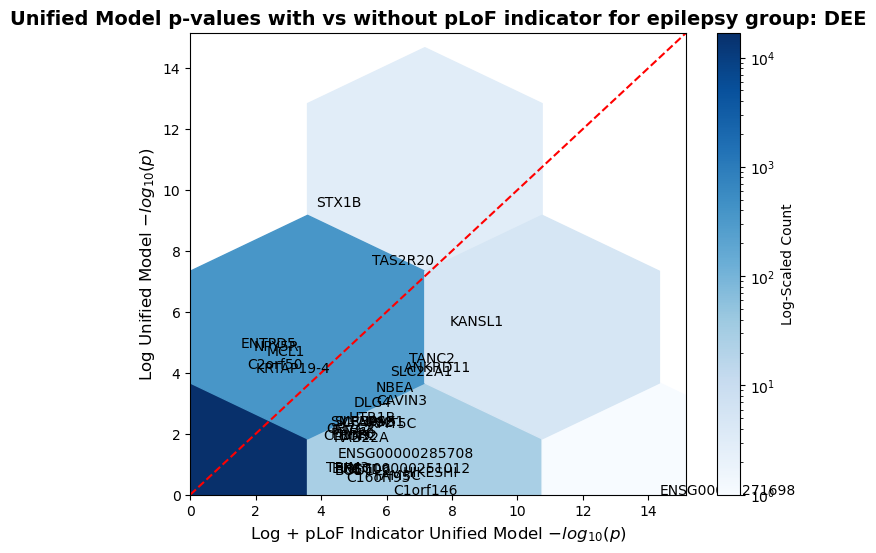

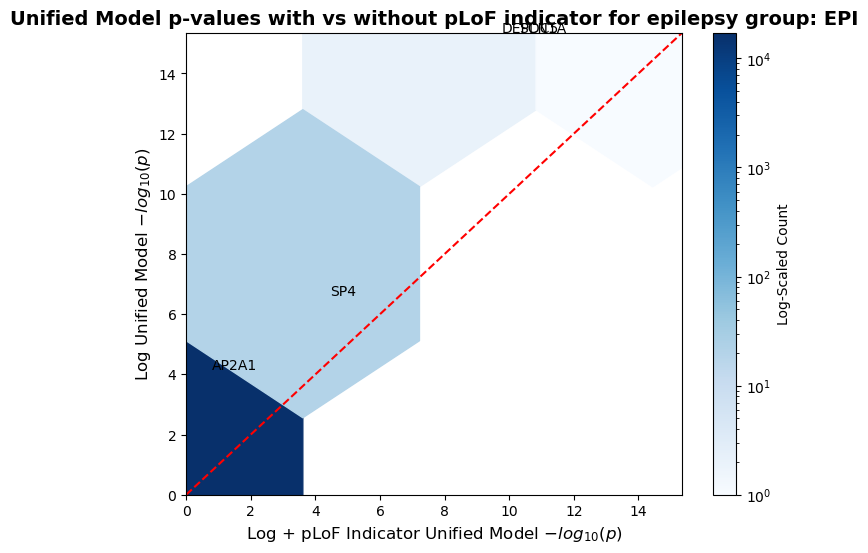

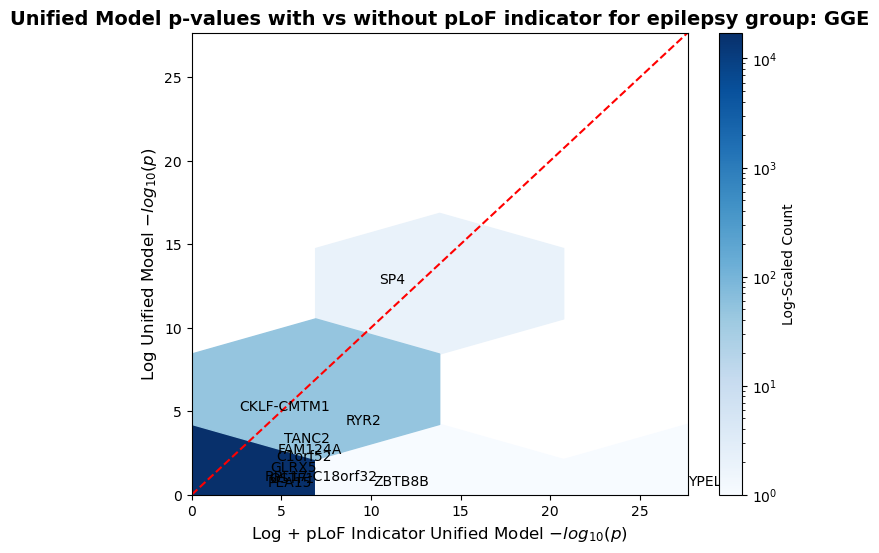

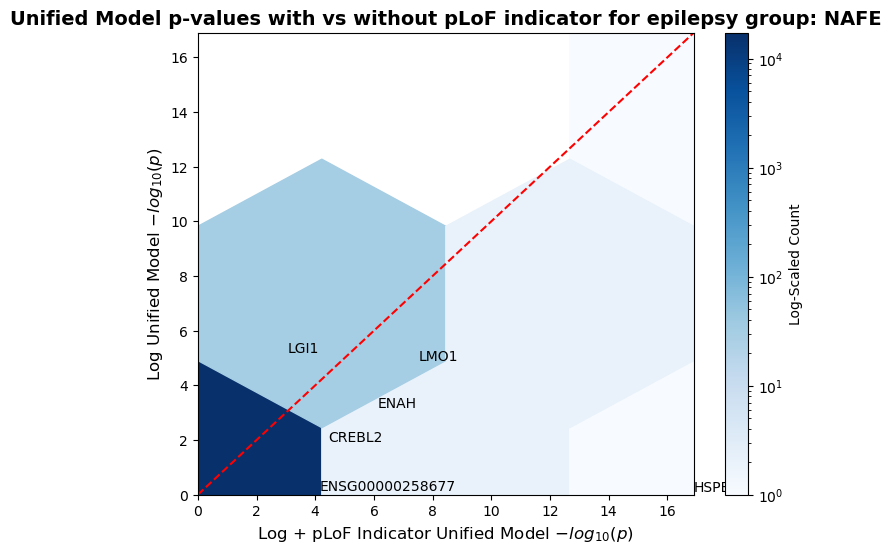

In [25]:
for group in unified_model_df['group'].unique():
    file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(unified_model_df[unified_model_df['group'] == group], log_unified_model_df[log_unified_model_df['group'] == group], on=['gene_id', 'gene_name', 'group'], suffixes=('_linear', '_log'))

        merged_pub_df['minus_log_pval_linear'] = -np.log10(merged_pub_df['p_unified_linear'])
        merged_pub_df['minus_log_pval_log'] = -np.log10(merged_pub_df['p_unified_log'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_pval_linear'].min(), merged_pub_df['minus_log_pval_log'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_pval_linear'].max(), merged_pub_df['minus_log_pval_log'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value

        # Create a hexbin (smoothscatter) plot with log scale
        plt.hexbin(merged_pub_df['minus_log_pval_linear'], merged_pub_df['minus_log_pval_log'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points with larger fontsize
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_pval_linear'] - row['minus_log_pval_log'])) > 2) & (max(row['minus_log_pval_linear'], row['minus_log_pval_log']) > 4):
                plt.text(row['minus_log_pval_linear'], row['minus_log_pval_log'], row['gene_name'], fontsize=10)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title (bolded)
        plt.xlabel(r'Log + pLoF Indicator Unified Model $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Log Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Unified Model p-values with vs without pLoF indicator for epilepsy group: {group}', fontsize=14, fontweight="bold")

        # Show color bar
        plt.colorbar(label='Log-Scaled Count')

        plt.show()

    else:
        print(f"No files found for group {group}")